Final Project
================
Collaborators: 
* Brian Demyan
* Alan Fuentes

In [23]:
# remove this line before commit
import sys
print(sys.executable)

c:\Users\Alan\AppData\Local\Programs\Python\Python311\python.exe


Frame the Problem and Look at the Big Picture
=====================================

1. **Define the objective in business terms:** Hired by the United States Department of Transportation in order to evaluate the factors which contribute to severe accidents, and in turn, longer traffic jams/delays. The US DoT is embarking on a project to address the most impactful factors, sparked by a new presidential administration's initiative to reduce automotive accident-related fatalities. The new administration has also championed initiatives to reduce traffic congestion across the United States by revamping automotive infrastructure (roads, highways, traffic control systems, etc.). The US DoT's project would effectively tie two loose ends at once. The US DoT requires an effective solution in order to correctly allocate resources to this issue. Their success in this endeavor will determine whether the DoT will see increases to their current budget or budget cuts.

2. **How will your solution be used?** It will be used in a pipeline to determine the factors that cause severe accidents/longer traffic delays so the DoT can allocate resources to their automotive safety/traffic decongestion project. It will periodically process new data at an annual rate after new yearly analytical summary data is released.

3. **How is a solution being used?** Currently no solution for this is used, the next step simply does not utilize this information and mostly relies on longer-term information. 

4. **How should you frame this problem?** This will be a supervised, binary classification problem where we are predicting which factors contribute to severe accidents/traffic delays. As the client only requires the information to be updated infrequently after new yearly data has been obtained, offline batch learning will be used. 

5. **How should performance be measured? Is the performance measure aligned with the business objective?** Performance will be measured using the F1 score, as we want to minimize false positives (predicting a severe accident/delay when there is none) and false negatives (missing actual severe accidents/delays). 

6. **What would be the minimum performance needed to reach the business objective?** The minimum should be an F1 score of 0.70, as anything below that might result in a system that fails to effectively predict severe accidents/delays or causes too many false alerts.

7. **What are comparable problems? Can you reuse (personal or readily available) experience or tools?** A similar classification problem would be the early spring and diseased squirrel analyses, as they were both binary classification problems.

8. **Is human expertise available?** The client is providing information they have compiled, but no previous work on this specific matter has been conducted.

9. **How would you solve the problem manually?** I would create a function to parse through the automotive accident data and return the counts of unique contributing factors in descending order in order to begin investigating them.

10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** 

* The period of data used (2016-2023) contains typical data (relative to historical records) and is not affected by some sort of short-term influence. 
* Recorded data and its units are accurate
* The data pertains to only the listed 49 states in the United States

In [30]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_val_score, train_test_split

import scipy
import pandas as pd
from pandas import read_csv

import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.cluster import DBSCAN

from sklearn import set_config
set_config(transform_output = "pandas")

Get the Data
================

1. **List the data you need and how much you need:**
2. **Find and document where you can get that data:**
3. **Get access authorizations**: None needed, publicy available.
4. **Create a workspace**: This notebook.
5. **Get the data**: 
6. **Convert the data to a format you can easily manipulate**: 
7. **Ensure sensitive information is deleted or protected**: Public data already has been anonymized.
8. **Check the size and type of data (time series, geographical, …)**: Done below.
9. **Sample a test set, put it aside, and never look at it (no data snooping!)**

In [2]:
# Load accident data 
accidents = read_csv('US_Accidents_March23_sampled_500k.csv')

In [ ]:
# interesting copilot line, not running yet
#accidents = accidents.dropna(subset=['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Weather_Condition'])

In [3]:
accidents.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

In [4]:
accidents["Wind_Direction"].value_counts()

Wind_Direction
CALM        62259
S           27182
W           24976
SSW         24805
WNW         24328
Calm        24022
NW          23889
SW          23648
WSW         22869
SSE         22644
NNW         21579
N           19947
SE          19156
E           17971
ESE         17185
NE          16880
ENE         16683
NNE         16639
VAR         16232
South       11371
West        10703
North        9857
Variable     7406
East         6572
Name: count, dtype: int64

array([[<Axes: title={'center': 'Severity'}>,
        <Axes: title={'center': 'Start_Lat'}>,
        <Axes: title={'center': 'Start_Lng'}>,
        <Axes: title={'center': 'End_Lat'}>],
       [<Axes: title={'center': 'End_Lng'}>,
        <Axes: title={'center': 'Distance(mi)'}>,
        <Axes: title={'center': 'Temperature(F)'}>,
        <Axes: title={'center': 'Wind_Chill(F)'}>],
       [<Axes: title={'center': 'Humidity(%)'}>,
        <Axes: title={'center': 'Pressure(in)'}>,
        <Axes: title={'center': 'Visibility(mi)'}>,
        <Axes: title={'center': 'Wind_Speed(mph)'}>],
       [<Axes: title={'center': 'Precipitation(in)'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

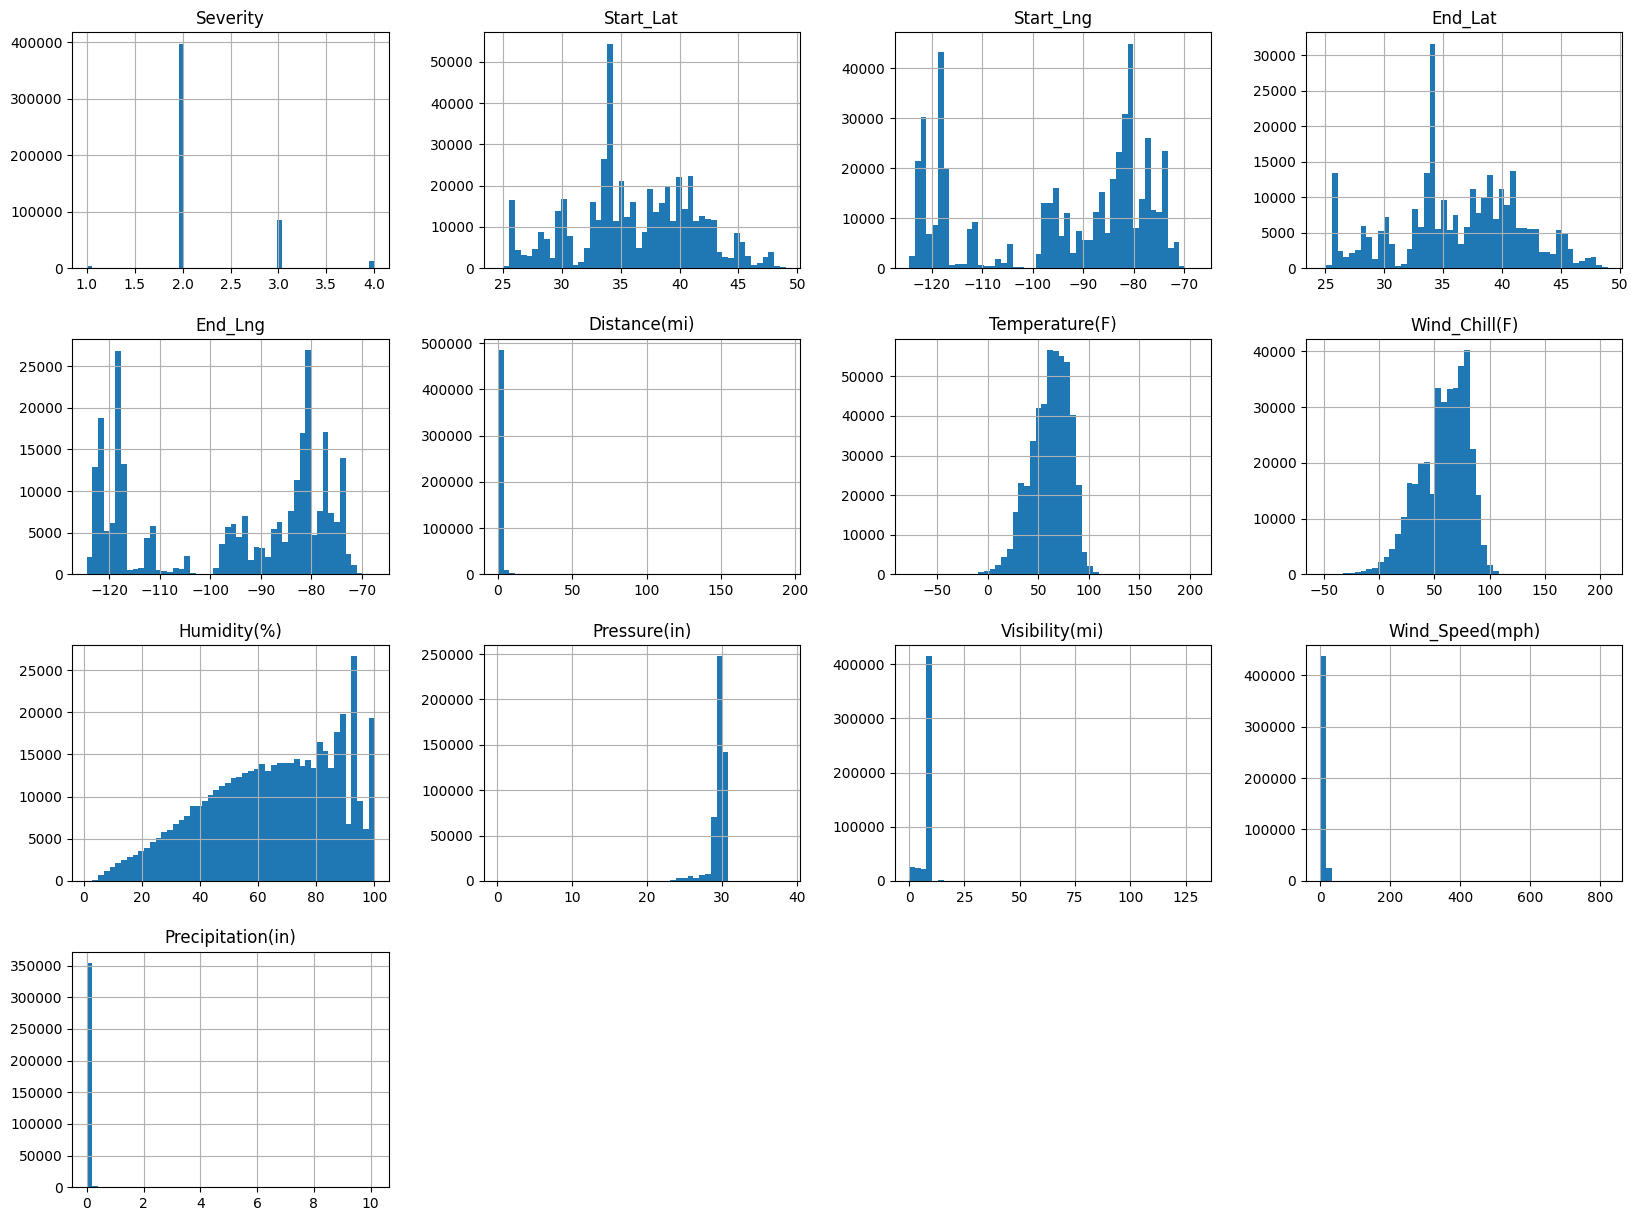

In [5]:
accidents.hist(bins=50, figsize=(20,15))

<Axes: >

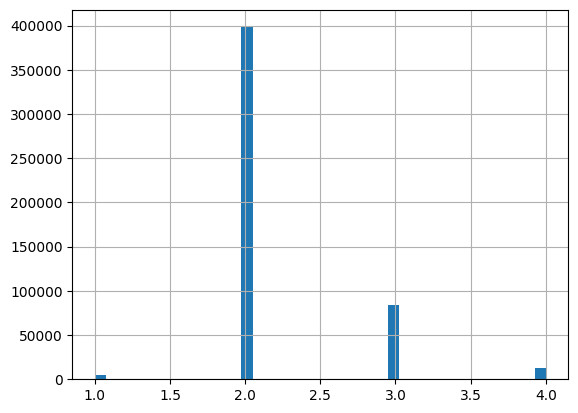

In [6]:
accidents["Severity"].hist(bins=40) 

In [7]:
accidents["Severity"].value_counts()

Severity
2    398142
3     84520
4     13064
1      4274
Name: count, dtype: int64

In [8]:
# Transform severity to binary, mapping 1 and 2 to 0 and 3 and 4 to 1
accidents["Severity_Binary"] = np.where(accidents["Severity"] <= 2, 0, 1)

# Drop the original severity column
accidents = accidents.drop(columns=["Severity"])

In [9]:
accidents["Severity_Binary"].value_counts()

Severity_Binary
0    402416
1     97584
Name: count, dtype: int64

<Axes: >

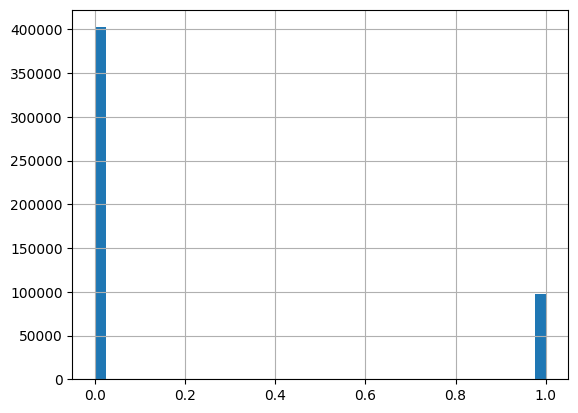

In [10]:
accidents["Severity_Binary"].hist(bins=40)

In [11]:
missing = accidents.isnull().sum().sum()
print(f"Missing values: {missing}")

percentage_missing = missing / (accidents.shape[0] * accidents.shape[1]) * 100
print(f"Percentage of missing values: {percentage_missing:.2f}%")

Missing values: 829873
Percentage of missing values: 3.61%


In [35]:
accidents.shape

(500000, 46)

In [12]:
accidents.describe()

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Severity_Binary
count,500000.000000,500000.000000,279623.000000,279623.000000,500000.000000,489534.000000,370983.000000,488870.000000,491072.000000,488709.000000,463013.000000,357384.000000,500000.000000
mean,36.206421,-94.736583,36.273192,-95.776553,0.564317,61.646254,58.229028,64.834921,29.536621,9.091540,7.681347,0.008289,0.195168
std,5.071411,17.405761,5.265333,18.120211,1.774872,19.000133,22.352246,22.826158,1.008666,2.708083,5.431361,0.101865,0.396330
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,-77.800000,-53.200000,1.000000,0.120000,0.000000,0.000000,0.000000,0.000000
25%,33.416823,-117.233047,33.474773,-117.778324,0.000000,49.000000,43.000000,48.000000,29.370000,10.000000,4.600000,0.000000,0.000000
50%,35.832147,-87.794365,36.192669,-88.039013,0.029000,64.000000,62.000000,67.000000,29.860000,10.000000,7.000000,0.000000,0.000000
75%,40.082443,-80.359601,40.181341,-80.252449,0.465000,76.000000,75.000000,84.000000,30.030000,10.000000,10.400000,0.000000,0.000000
max,48.999569,-67.484130,48.998901,-67.484130,193.479996,207.000000,207.000000,100.000000,38.440000,130.000000,822.800000,10.130000,1.000000


In [14]:
accidents["Start_Time"].value_counts()

Start_Time
2021-01-26 16:16:13    20
2021-01-26 16:17:33    10
2021-02-16 06:42:43    10
2021-11-21 18:37:51    10
2020-12-16 13:53:25     9
                       ..
2019-11-09 16:02:00     1
2021-12-15 07:30:00     1
2021-12-19 16:25:00     1
2020-05-15 17:20:56     1
2022-04-02 23:23:13     1
Name: count, Length: 487027, dtype: int64

In [15]:
accidents["End_Time"].value_counts()

End_Time
2021-11-22 08:00:00              11
2017-05-15 15:22:55               8
2019-10-26 09:14:51               7
2020-02-07 00:00:00               6
2020-02-08 00:00:00               5
                                 ..
2021-12-15 07:50:30               1
2021-12-19 17:40:37               1
2022-04-13 21:33:44               1
2020-05-15 17:50:56               1
2022-12-04 01:56:53.000000000     1
Name: count, Length: 493821, dtype: int64

In [16]:
accidents["Description"].value_counts() 

Description
A crash has occurred causing no to minimum delays. Use caution.                                                           592
Accident                                                                                                                  419
An unconfirmed report of a crash has been received. Use caution.                                                          243
A crash has occurred with minimal delay to traffic. Prepare to slow or move over for worker safety.                       183
A crash has occurred use caution.                                                                                         181
                                                                                                                         ... 
Stationary traffic on OR-47 from NW Martin Rd (OR-47) to OR-8/Tualatin Valley Hwy/Pacific Ave (OR-47) due to accident.      1
Incident on MILITARY TRL near WESTGATE AVE Drive with caution.                                            

In [17]:
accidents["Street"].value_counts()

Street
I-95 N                   4973
I-95 S                   4866
I-5 N                    4552
I-10 E                   3583
I-10 W                   3484
                         ... 
Gummow Dr                   1
 Hart Flat Rd               1
Big Tujunga Canyon Rd       1
 W Spotswood Trl            1
 Forest Ridge Dr            1
Name: count, Length: 88272, dtype: int64

In [18]:
accidents["City"].value_counts()

City
Miami                         12141
Houston                       11031
Los Angeles                   10299
Charlotte                      8979
Dallas                         8245
                              ...  
Wrenshall                         1
Kitzmiller                        1
Halfway                           1
Cocoa Beach-Cape Canaveral        1
Roland                            1
Name: count, Length: 9488, dtype: int64

In [19]:
accidents["County"].value_counts()

County
Los Angeles    34247
Miami-Dade     16248
Orange         15350
Harris         11770
Dallas          9864
               ...  
Vinton             1
Hardeman           1
Crockett           1
Shackelford        1
Upton              1
Name: count, Length: 1606, dtype: int64

In [20]:
accidents["State"].value_counts()

State
CA    113274
FL     56710
TX     37355
SC     24737
NY     22594
NC     21750
VA     19515
PA     19351
MN     12333
OR     11559
AZ     11150
GA     11079
IL     10904
TN     10850
MI     10518
LA      9651
MD      9128
NJ      9020
OH      7678
WA      7004
AL      6585
UT      6310
CO      5924
OK      5296
MO      5025
CT      4602
IN      4320
MA      3917
WI      2290
KY      2101
NE      1893
MT      1871
IA      1724
AR      1483
KS      1362
NV      1343
DC      1207
RI      1093
MS       977
DE       907
WV       851
ID       718
NM       636
NH       635
WY       254
ND       238
ME       202
VT        57
SD        19
Name: count, dtype: int64

In [21]:
accidents["Timezone"].value_counts()

Timezone
US/Eastern     231397
US/Pacific     133987
US/Central     106012
US/Mountain     28097
Name: count, dtype: int64

In [22]:
accidents["Airport_Code"].value_counts()

Airport_Code
KCQT    7756
KRDU    6845
KMCJ    6574
KBNA    6428
KCLT    6331
        ... 
KEAR       1
KDIJ       1
KPOF       1
KAHQ       1
K4CR       1
Name: count, Length: 1878, dtype: int64

In [23]:
accidents["Weather_Timestamp"].value_counts()

Weather_Timestamp
2022-03-13 01:53:00    92
2021-01-26 15:53:00    48
2022-04-13 16:53:00    40
2021-12-03 16:53:00    40
2021-01-15 22:53:00    39
                       ..
2022-02-25 07:21:00     1
2021-08-08 14:56:00     1
2022-07-09 19:04:00     1
2022-08-20 12:56:00     1
2022-12-03 23:52:00     1
Name: count, Length: 255623, dtype: int64

In [24]:
accidents["Weather_Condition"].value_counts()   

Weather_Condition
Fair                  166053
Mostly Cloudy          65398
Cloudy                 53107
Clear                  52379
Partly Cloudy          45125
                       ...  
Volcanic Ash               1
Mist / Windy               1
Light Blowing Snow         1
Low Drifting Snow          1
Sand                       1
Name: count, Length: 108, dtype: int64

In [13]:
accidents.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Start_Time             500000 non-null  object 
 3   End_Time               500000 non-null  object 
 4   Start_Lat              500000 non-null  float64
 5   Start_Lng              500000 non-null  float64
 6   End_Lat                279623 non-null  float64
 7   End_Lng                279623 non-null  float64
 8   Distance(mi)           500000 non-null  float64
 9   Description            499999 non-null  object 
 10  Street                 499309 non-null  object 
 11  City                   499981 non-null  object 
 12  County                 500000 non-null  object 
 13  State                  500000 non-null  object 
 14  Zipcode                499884 non-nu

In [ ]:
accidents

Stratification
===========

In [25]:
# Binary classifier stratification for binary severity feature

X = accidents.drop(columns=['Severity_Binary'])
y = accidents['Severity_Binary']

# Split the dataset with stratification for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verify the distribution
print("Original distribution:", dict(zip(*np.unique(y, return_counts=True))))
print("Training distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Testing distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

Original distribution: {np.int64(0): np.int64(402416), np.int64(1): np.int64(97584)}
Training distribution: {np.int64(0): np.int64(321933), np.int64(1): np.int64(78067)}
Testing distribution: {np.int64(0): np.int64(80483), np.int64(1): np.int64(19517)}


Explore the Data
=============

Notes:
* I want lots of written information, the only code to keep when submitting is the code to output numbers, tables, or plots that you refer to in your writing
* During exploration, it is reasonable to remove unreasonable outliers (and document that you are doing so and how you are classifying what an outlier is) before doing further analysis
  * There are differences in outliers: ones that are real and ones that are errors. For example, if a height was entered as 7'1" for Shaq O'Neal, that is a real outlier, it has meaning. If a height was entered as 7'1" for a random person, that is an error. You should (try to) remove (only) the error/non-useful ones.
* You will need to explore how to work with date-times, Pandas has a very wide range of utilities for working with them, one particular thing to possibly use is extracting components of the date-time (like hours in the day or day-of-week)
* Document all important things, make sure to put headers for the separate steps, and keep everything organized

Reminder about the 9 steps (points in parentheses):
1. (1) Copy the data for exploration, downsampling to a manageable size if necessary.
2. (6) Study each attribute and its characteristics: Name; Type (categorical, numerical, bounded, text, structured, …); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, …); Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, …) (format as a nice markdown table!)
3. (2) For supervised learning tasks, identify the target attribute(s)
4. (4) Visualize the data
5. (5) Study the correlations between attributes
6. (2) Study how you would solve the problem manually (using the data you have)
7. (3) Identify the promising transformations you may want to apply
8. (2) Identify extra data that would be useful (discuss it, but don't actually go through with it)
9. (0) Document what you have learned (included in the other steps - it is actually worth most of the points!)

In [26]:
X_combined = X_train.copy()

y_combined = y_train.copy()

In [47]:
from sklearn.feature_selection import VarianceThreshold

# Filter out non-numerical and non-boolean features
numerical_boolean_features = X_combined.select_dtypes(include=['number', 'bool'])

# Remove features with low variance
selector = VarianceThreshold(threshold=0.02) # Used 0.02 to identify features with low variance (2%)
selector.fit(numerical_boolean_features)

# Features that passed the threshold
low_variance_features = numerical_boolean_features.columns[~selector.get_support()]
print("Low variance features to drop:", low_variance_features)

Low variance features to drop: Index(['Precipitation(in)', 'Amenity', 'Bump', 'Give_Way', 'No_Exit',
       'Railway', 'Roundabout', 'Traffic_Calming', 'Turning_Loop'],
      dtype='object')


In [14]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Filter out categorical features
categorical_features = X_combined.select_dtypes(include=['object'])

# Encode categorical features using LabelEncoder
encoded_features = pd.DataFrame()
for column in categorical_features.columns:
    le = LabelEncoder()
    encoded_features[column] = le.fit_transform(categorical_features[column])

# Compute chi2 scores and p-values for categorical features
chi_scores, p_values = chi2(encoded_features, y_combined)

# Display scores and p-values
chi_scores_df = pd.DataFrame({
    'Feature': encoded_features.columns,
    'Chi-Square Score': chi_scores,
    'P-Value': p_values
})

# Display scores
print(chi_scores_df.sort_values(by='Chi-Square Score', ascending=False))

                  Feature  Chi-Square Score        P-Value
3                End_Time      2.193779e+09   0.000000e+00
2              Start_Time      2.156483e+09   0.000000e+00
13      Weather_Timestamp      1.095476e+09   0.000000e+00
0                      ID      6.571684e+08   0.000000e+00
5                  Street      4.743520e+07   0.000000e+00
4             Description      9.047580e+06   0.000000e+00
9                 Zipcode      5.789387e+06   0.000000e+00
6                    City      5.596337e+05   0.000000e+00
7                  County      3.631574e+05   0.000000e+00
12           Airport_Code      6.489217e+04   0.000000e+00
15      Weather_Condition      5.779195e+04   0.000000e+00
1                  Source      2.386416e+04   0.000000e+00
14         Wind_Direction      2.101215e+03   0.000000e+00
11               Timezone      9.255830e+02  2.694490e-203
8                   State      7.763828e+02  7.361509e-171
19  Astronomical_Twilight      1.166977e+02   3.343368e-

In [ ]:
encoded_features

In [ ]:
# Initialize and train the RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_combined, y_combined)

# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with the feature names and their importance
feature_importances_df = pd.DataFrame(
    {"Feature": X_combined.columns, "Importance": feature_importances}
)

# Sort the Dataframe by importance
feature_importances_df = feature_importances_df.sort_values("Importance", ascending=False)

# Display the feature importances
print(feature_importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df["Feature"], feature_importances_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()

ValueError: could not convert string to float: 'A-6038198'

In [15]:
data = pd.concat([X_combined, y_combined], axis=1)

In [ ]:
data

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400000 entries, 99896 to 476005
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     400000 non-null  object 
 1   Source                 400000 non-null  object 
 2   Start_Time             400000 non-null  object 
 3   End_Time               400000 non-null  object 
 4   Start_Lat              400000 non-null  float64
 5   Start_Lng              400000 non-null  float64
 6   End_Lat                223509 non-null  float64
 7   End_Lng                223509 non-null  float64
 8   Distance(mi)           400000 non-null  float64
 9   Description            399999 non-null  object 
 10  Street                 399437 non-null  object 
 11  City                   399987 non-null  object 
 12  County                 400000 non-null  object 
 13  State                  400000 non-null  object 
 14  Zipcode                399913 non-nul

array([[<Axes: title={'center': 'Start_Lat'}>,
        <Axes: title={'center': 'Start_Lng'}>,
        <Axes: title={'center': 'End_Lat'}>,
        <Axes: title={'center': 'End_Lng'}>],
       [<Axes: title={'center': 'Distance(mi)'}>,
        <Axes: title={'center': 'Temperature(F)'}>,
        <Axes: title={'center': 'Wind_Chill(F)'}>,
        <Axes: title={'center': 'Humidity(%)'}>],
       [<Axes: title={'center': 'Pressure(in)'}>,
        <Axes: title={'center': 'Visibility(mi)'}>,
        <Axes: title={'center': 'Wind_Speed(mph)'}>,
        <Axes: title={'center': 'Precipitation(in)'}>],
       [<Axes: title={'center': 'Severity_Binary'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

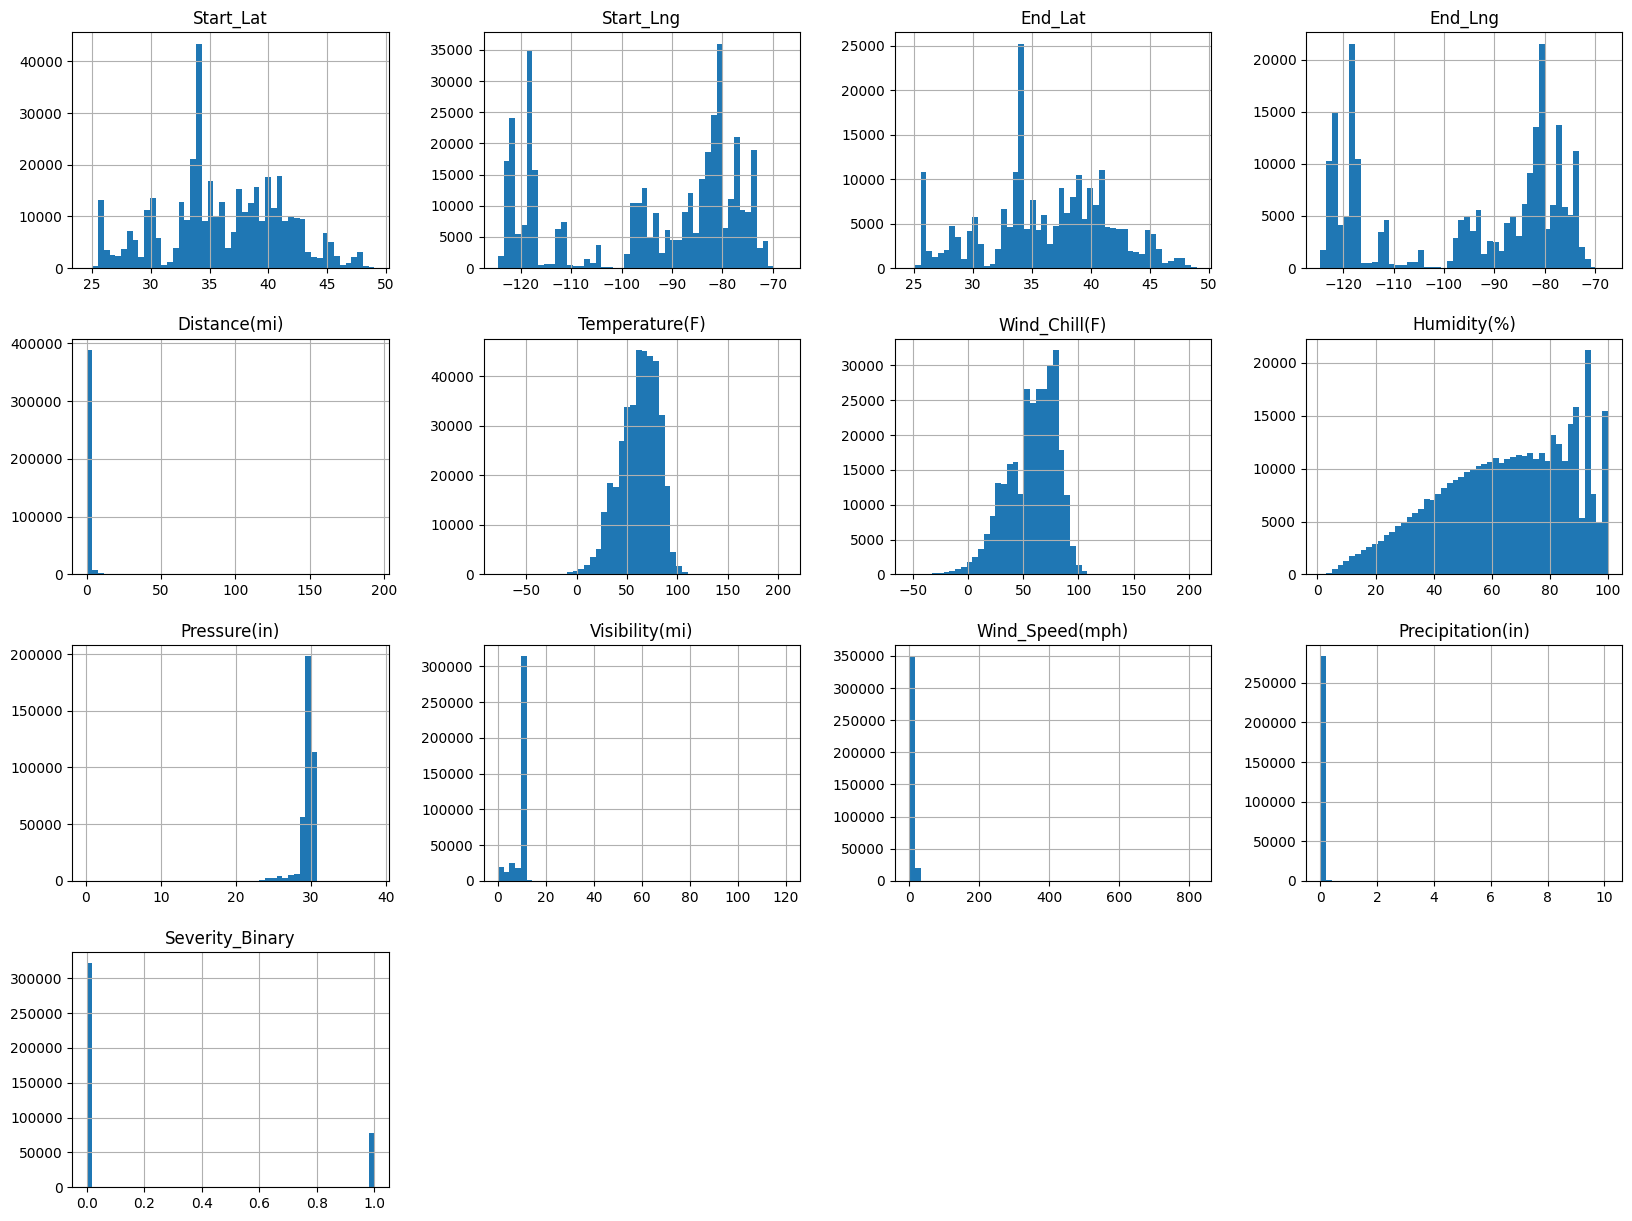

In [17]:
data.hist(bins=50, figsize=(20,15))

- The range of the most frequent visibility observations lies between 0.5 and 10 miles

(np.int64(40), np.int64(32))

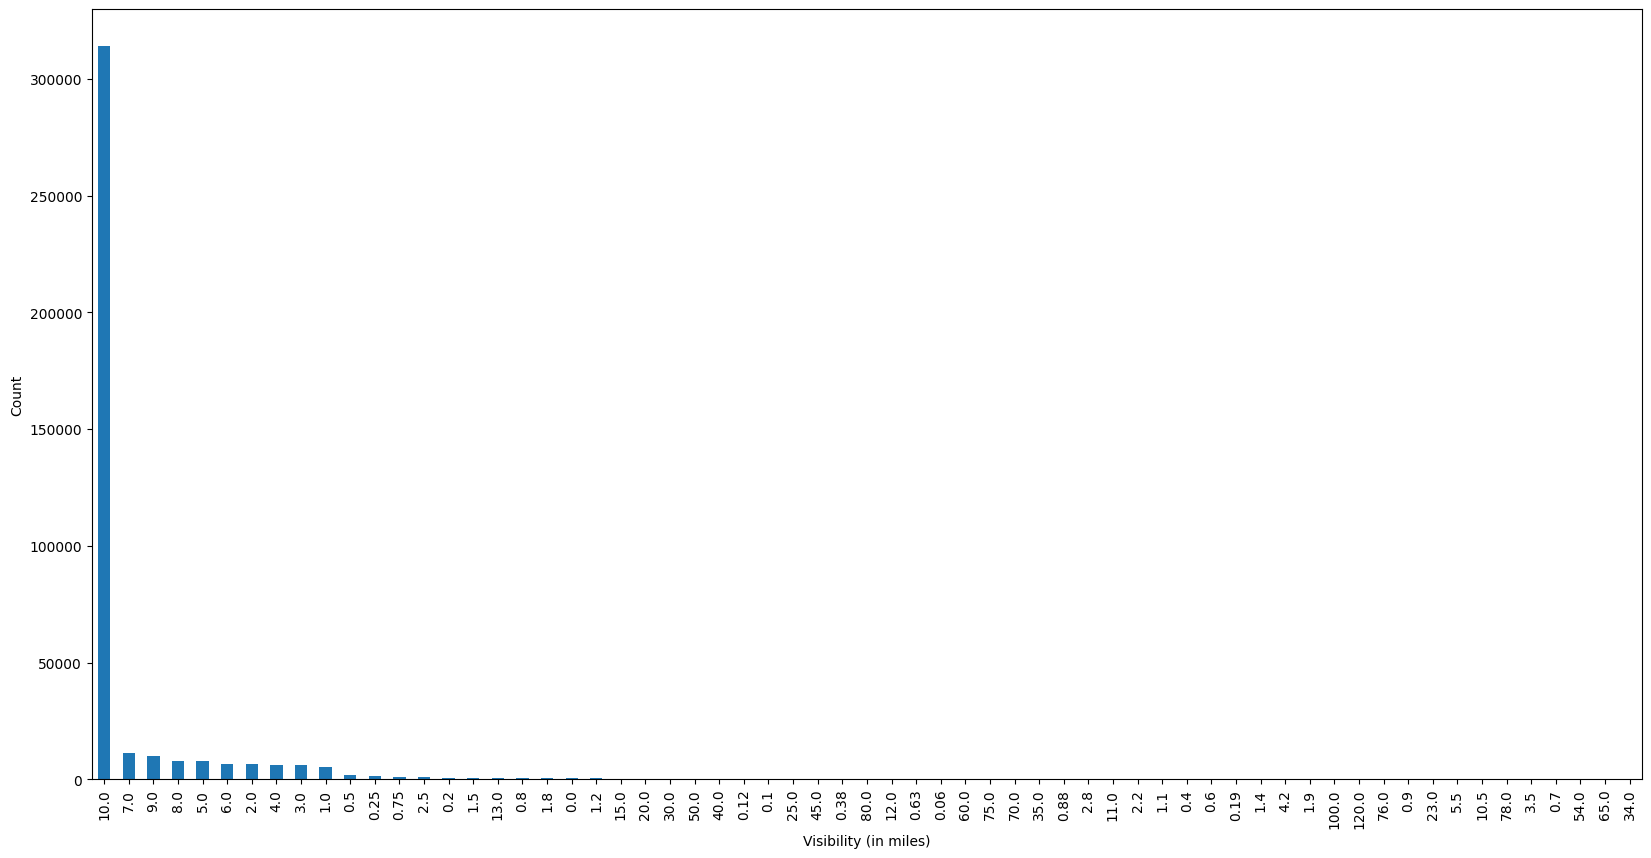

In [18]:
# Look at the distribution of Visibility
counts = data["Visibility(mi)"].value_counts()
counts.plot.bar(figsize=(20, 10))
plt.xlabel("Visibility (in miles)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

(np.int64(54), np.int64(36))

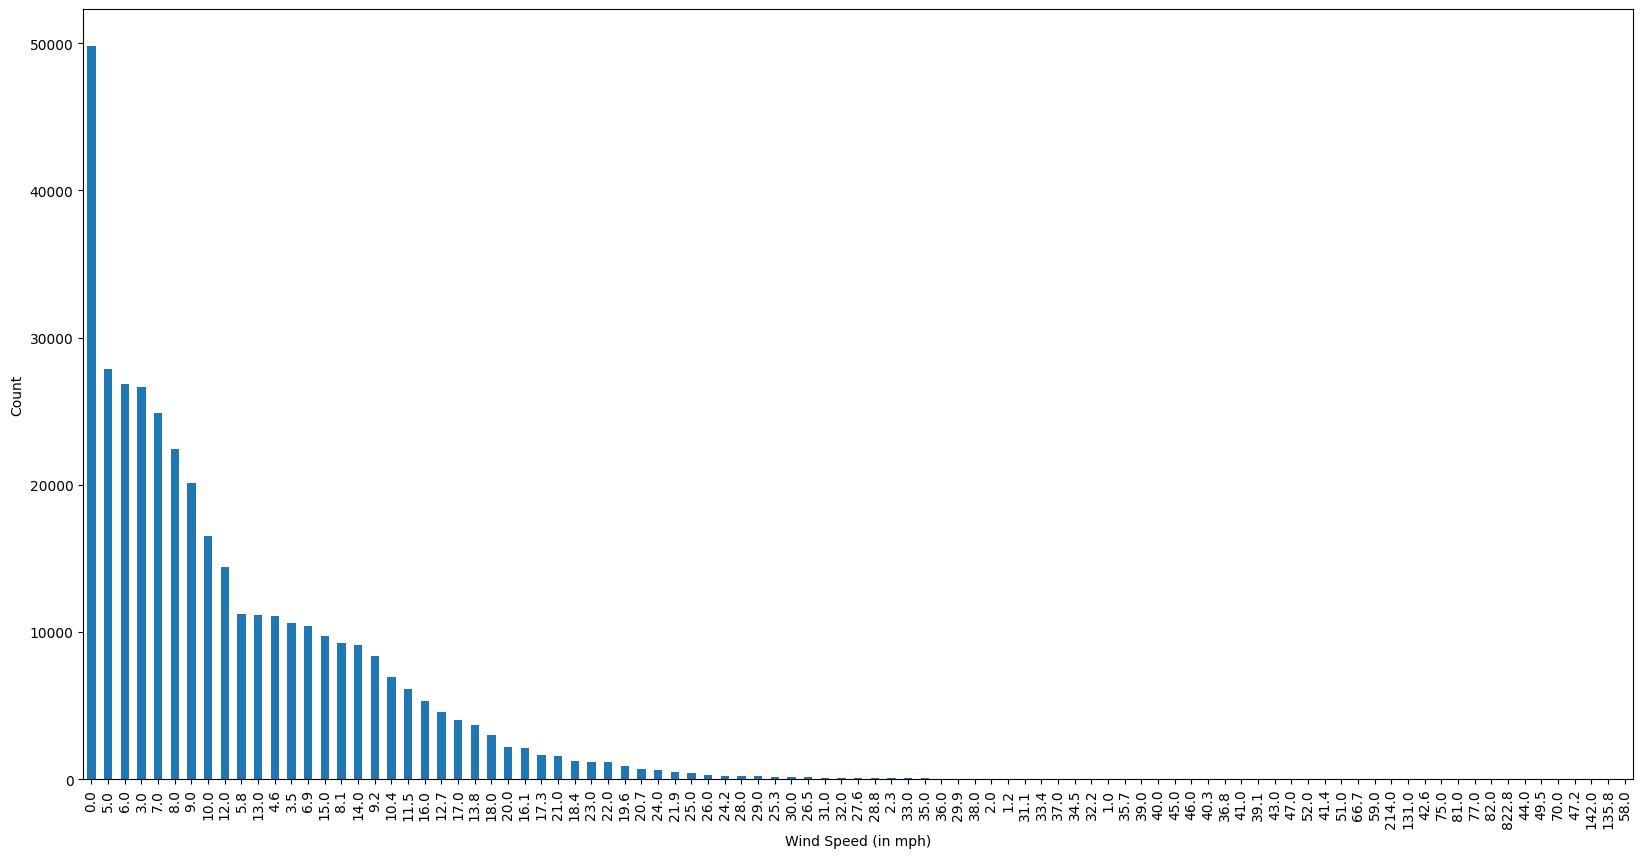

In [19]:
# Look at the distribution of Wind_Speed
counts = data["Wind_Speed(mph)"].value_counts()
counts.plot.bar(figsize=(20, 10))
plt.xlabel("Wind Speed (in mph)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

(np.int64(538), np.int64(360))

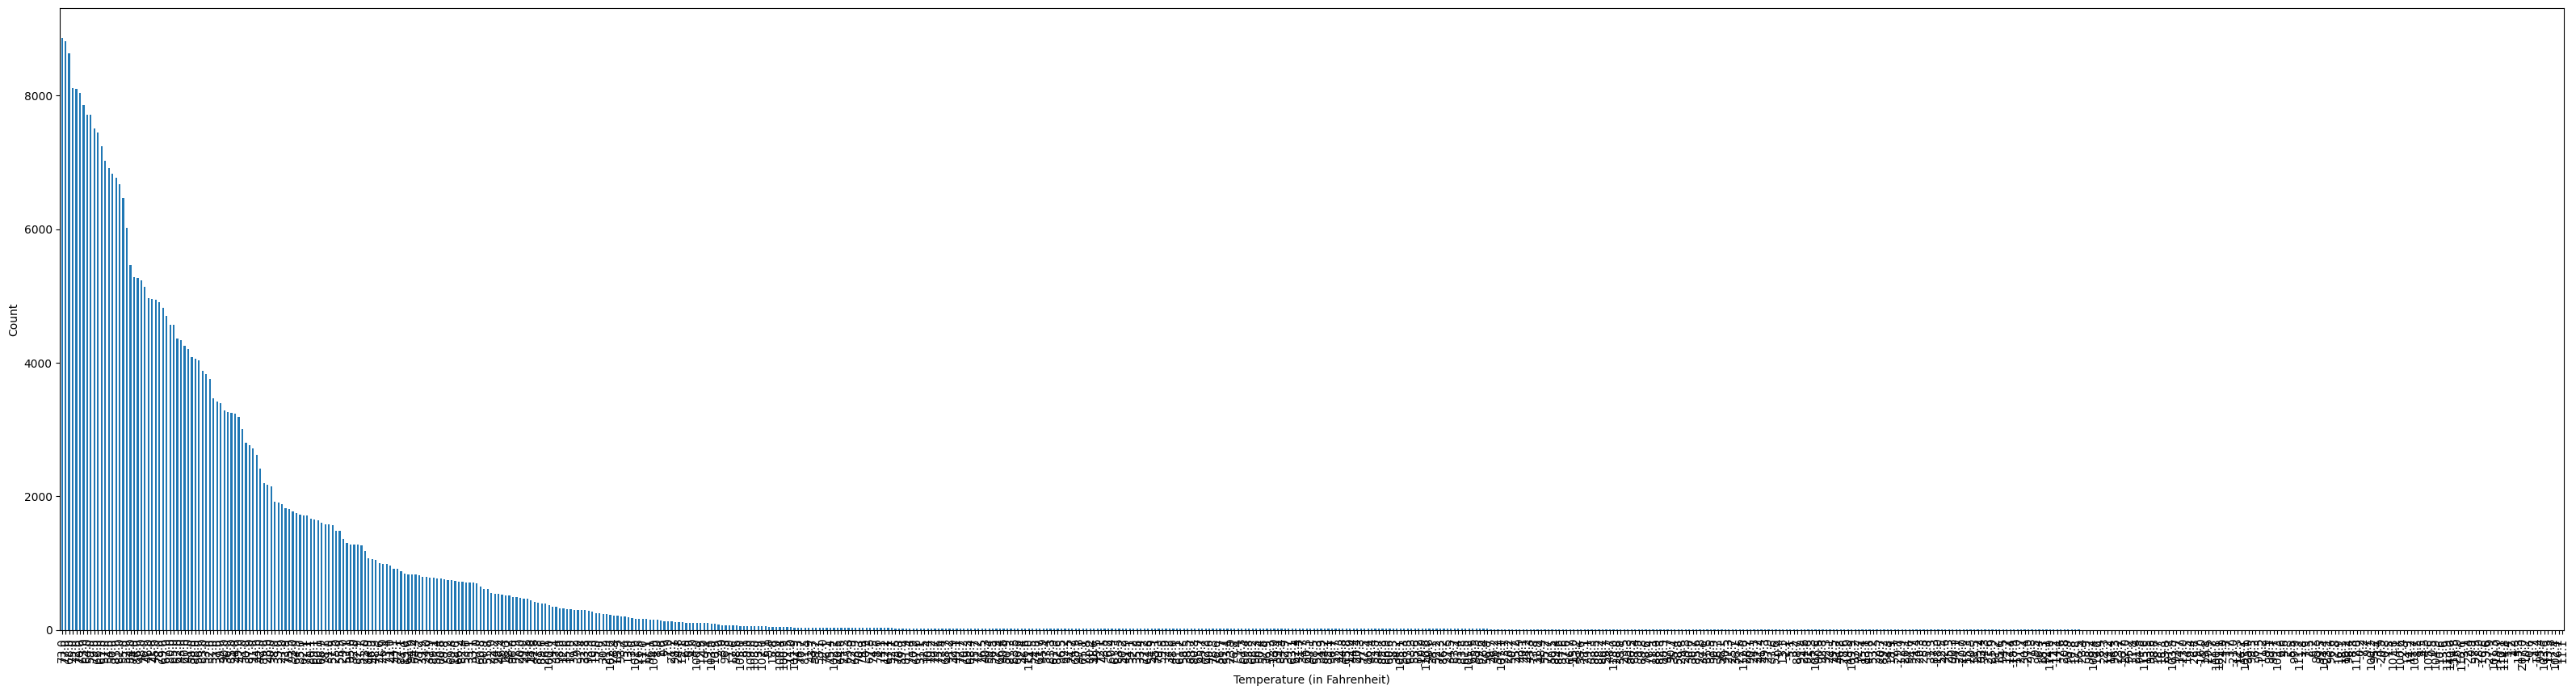

In [20]:
# Look at the distribution of Temperature
counts = data["Temperature(F)"].value_counts()
counts.plot.bar(figsize=(40, 10))
plt.xlabel("Temperature (in Fahrenheit)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

(np.int64(4), np.int64(2))

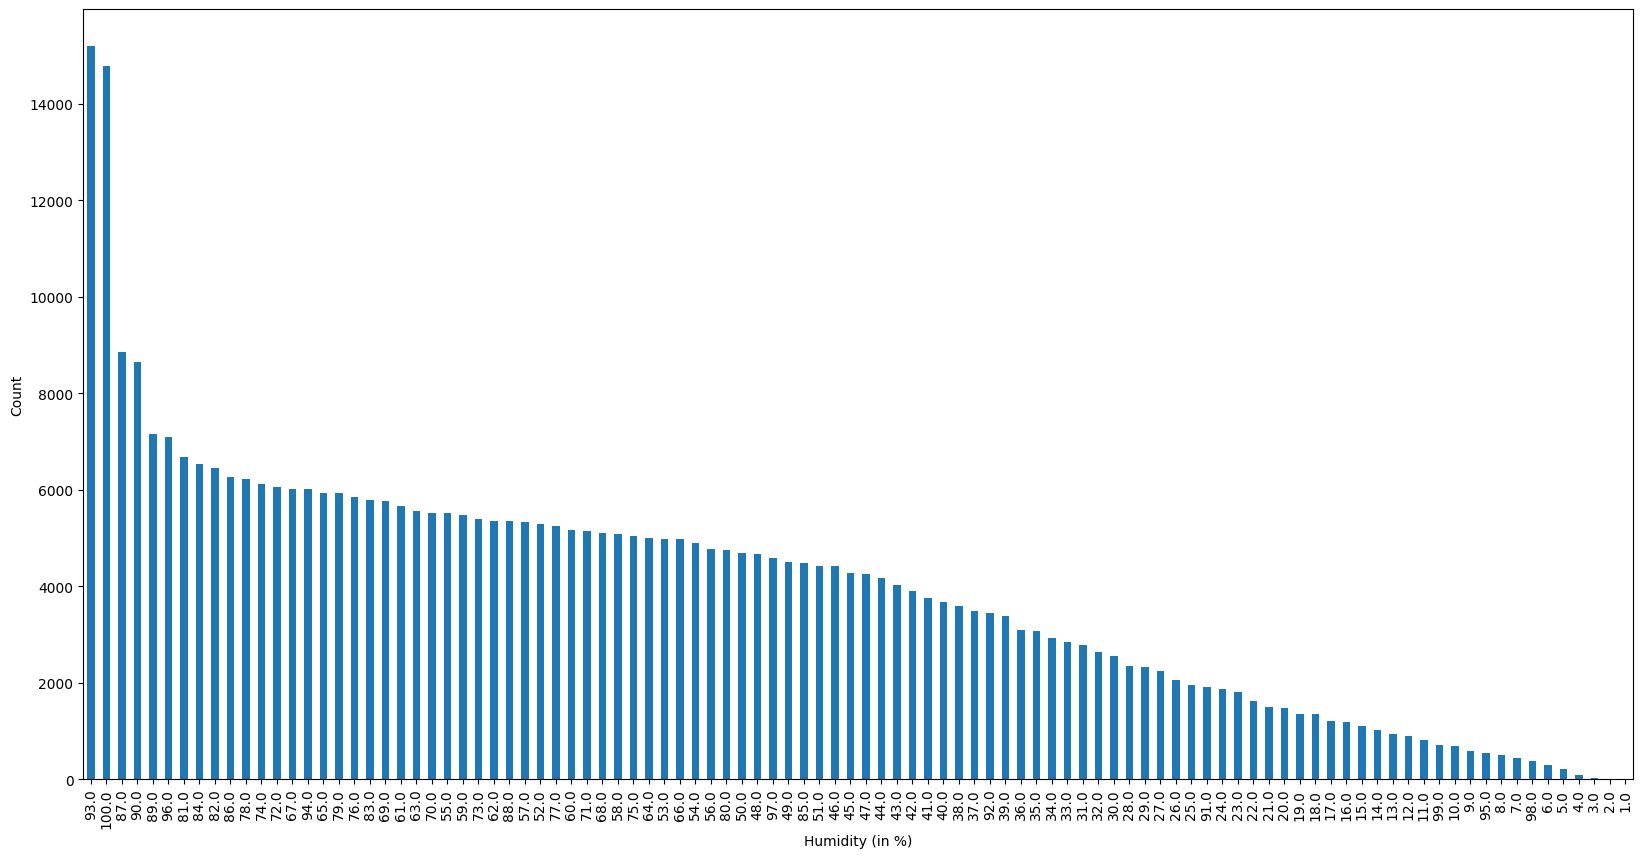

In [21]:
# Look at the distribution of Humidity
counts = data["Humidity(%)"].value_counts()
counts.plot.bar(figsize=(20, 10))
plt.xlabel("Humidity (in %)")
plt.ylabel("Count")
((counts / len(data) * 100) < 0.05).sum(), ((counts / len(data) * 100) < 0.005).sum()

<Axes: xlabel='Temperature(F)', ylabel='Severity_Binary'>

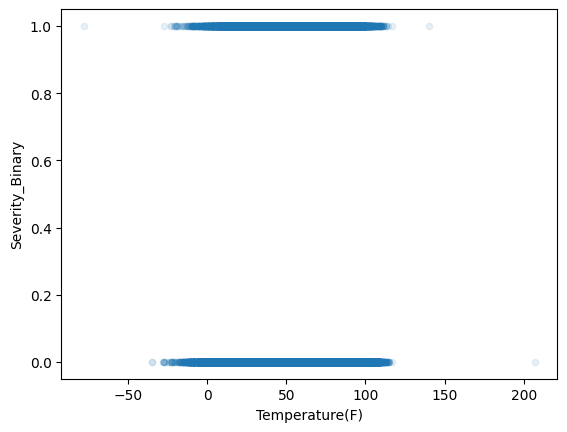

In [22]:
# Compare severity with temperature
data.plot(kind="scatter", x="Temperature(F)", y="Severity_Binary", alpha=0.1)

<Axes: title={'center': 'Temperature(F)'}, xlabel='Severity_Binary'>

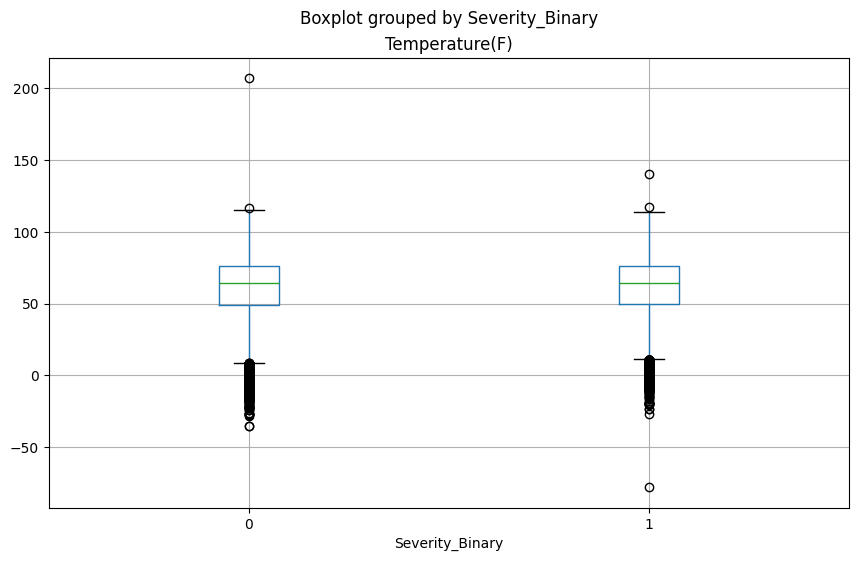

In [23]:
# compare severity with state using a boxplot
data.boxplot(column="Temperature(F)", by="Severity_Binary", figsize=(10, 6))

<Axes: xlabel='Severity_Binary'>

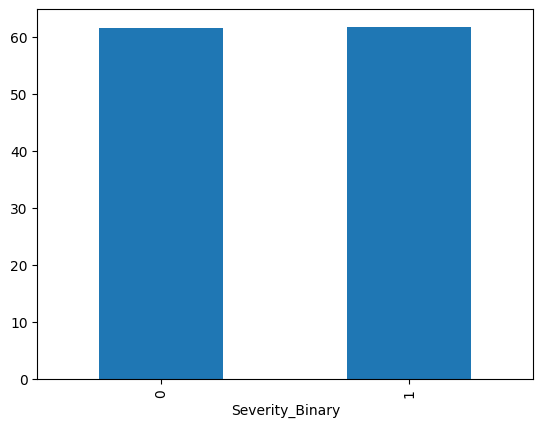

In [26]:
# Compare severity with state using a barplot
data.groupby("Severity_Binary")["Temperature(F)"].mean().plot(kind="bar")


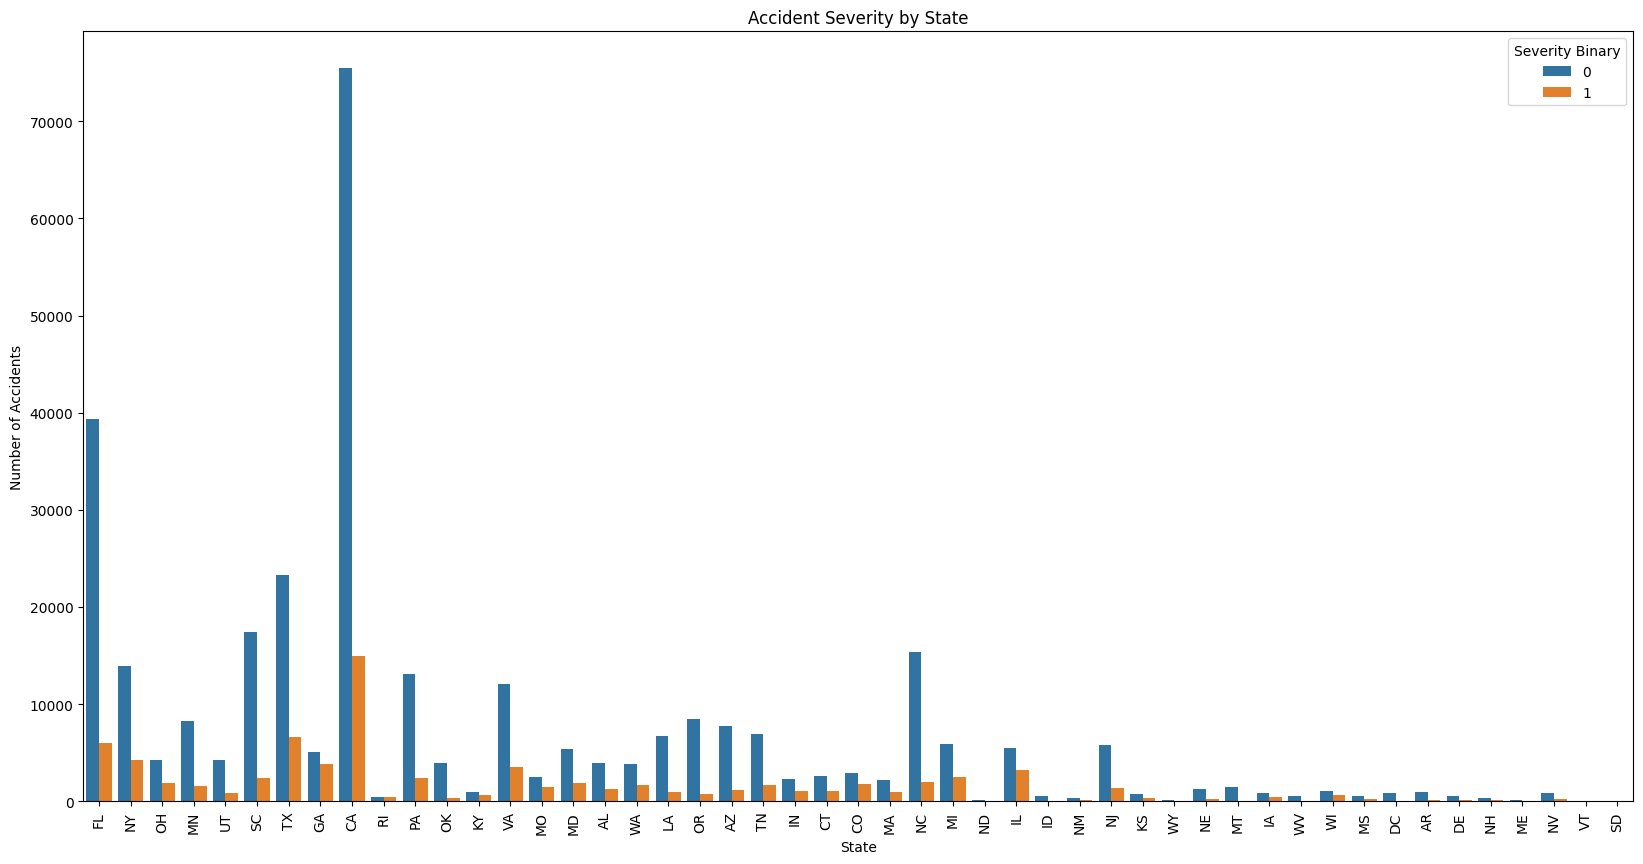

In [24]:
plt.figure(figsize=(20, 10))
sns.countplot(data=data, x='State', hue='Severity_Binary')
plt.title('Accident Severity by State')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity Binary')
plt.xticks(rotation=90)
plt.show()

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400000 entries, 99896 to 476005
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     400000 non-null  object 
 1   Source                 400000 non-null  object 
 2   Start_Time             400000 non-null  object 
 3   End_Time               400000 non-null  object 
 4   Start_Lat              400000 non-null  float64
 5   Start_Lng              400000 non-null  float64
 6   End_Lat                223509 non-null  float64
 7   End_Lng                223509 non-null  float64
 8   Distance(mi)           400000 non-null  float64
 9   Description            399999 non-null  object 
 10  Street                 399437 non-null  object 
 11  City                   399987 non-null  object 
 12  County                 400000 non-null  object 
 13  State                  400000 non-null  object 
 14  Zipcode                399913 non-nul

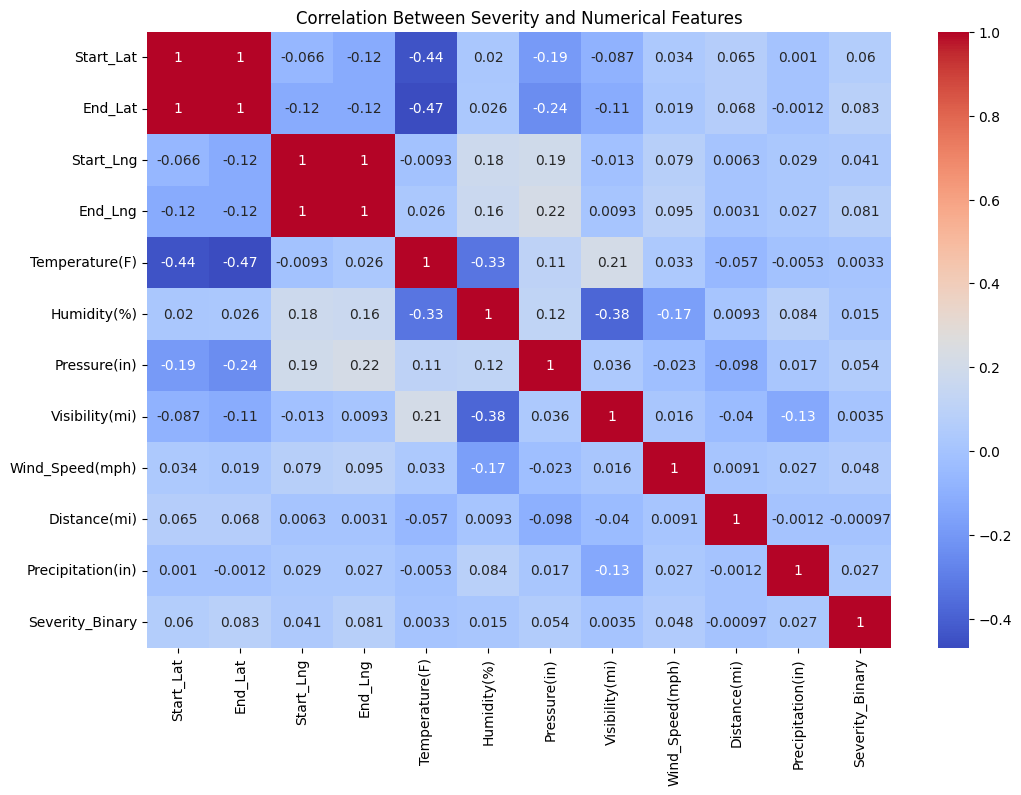

In [26]:
attrs = ["Start_Lat", "End_Lat", "Start_Lng", "End_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", 
         "Visibility(mi)", "Wind_Speed(mph)", "Distance(mi)", "Precipitation(in)", "Severity_Binary"]
corr_matrix = data[attrs].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Severity and Numerical Features")
plt.show()

In [27]:
def scatter_plot(x_name, x_data, y_name, y_data, extra = None):
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.scatter(x_data, y_data, s=2, alpha=0.2)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    if extra: extra()

    plt.subplot(1, 2, 2)
    plt.hist2d(x_data, y_data, bins=2304, norm=mcolors.LogNorm())
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    if extra: extra()

    plt.tight_layout()

def corr(x_name, y_name):
    return data[x_name].corr(data[y_name])

Correlation between Temperature(F) and Humidity(%): -0.33


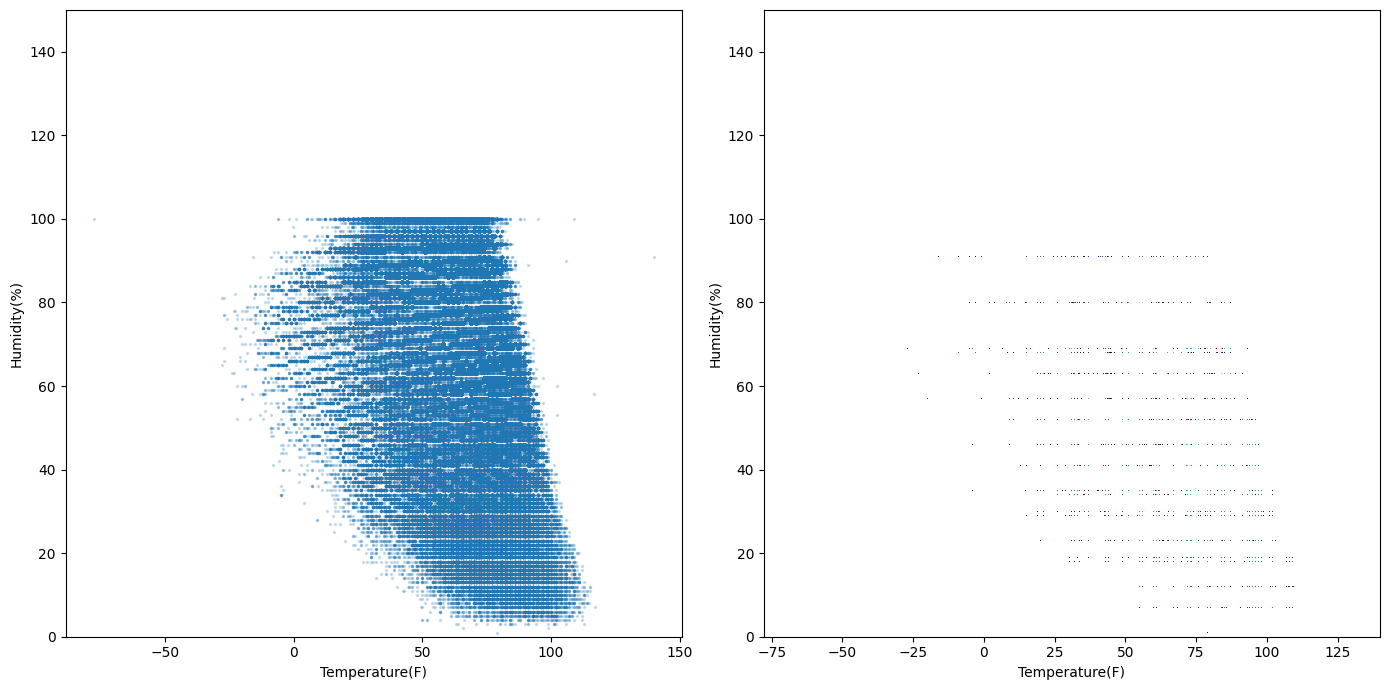

In [28]:
# Drop rows with NaN values in the relevant columns
data_clean = data.dropna(subset=['Temperature(F)', 'Humidity(%)'])

# Distances and Durations Correlation - decent linear correlation: .81
scatter_plot(
    'Temperature(F)', data_clean['Temperature(F)'],
    'Humidity(%)', data_clean['Humidity(%)'],
    extra=lambda: plt.ylim(0, 150)
)

# Calculate and print the correlation
correlation = data_clean['Temperature(F)'].corr(data_clean['Humidity(%)'])
print(f"Correlation between Temperature(F) and Humidity(%): {correlation:.2f}")

Turning loop contains all false values, so it doesn't tell us much = should be removed

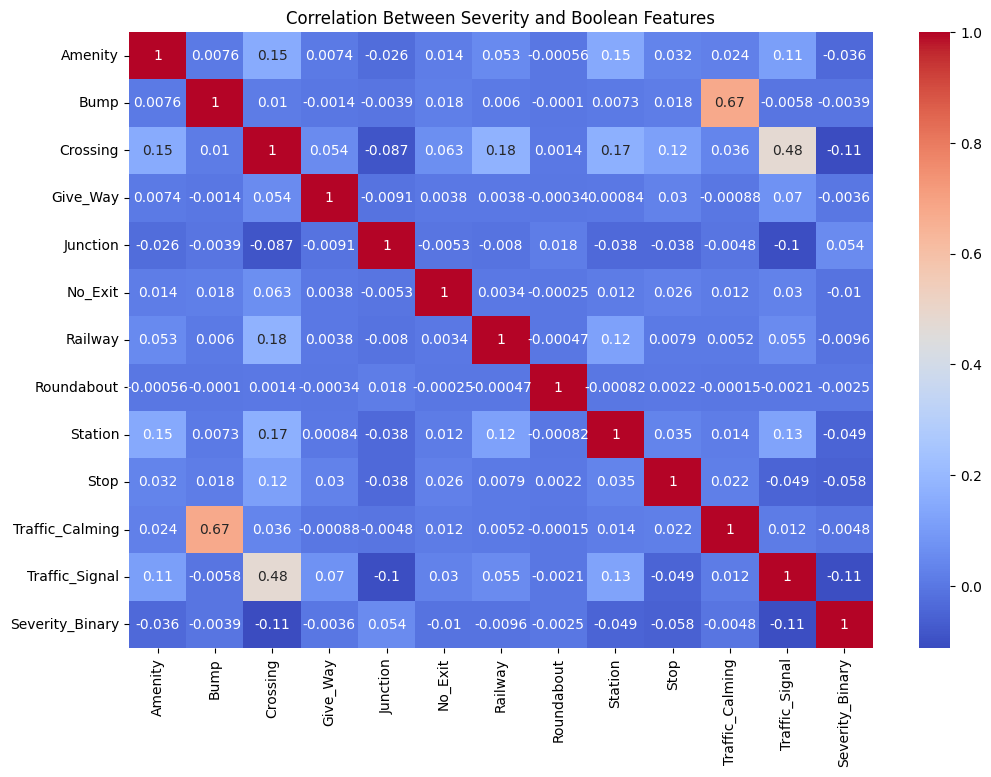

In [30]:
bool_attrs = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
          "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Severity_Binary"]

corr_matrix2 = data[bool_attrs].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm')
plt.title("Correlation Between Severity and Boolean Features")
plt.show()

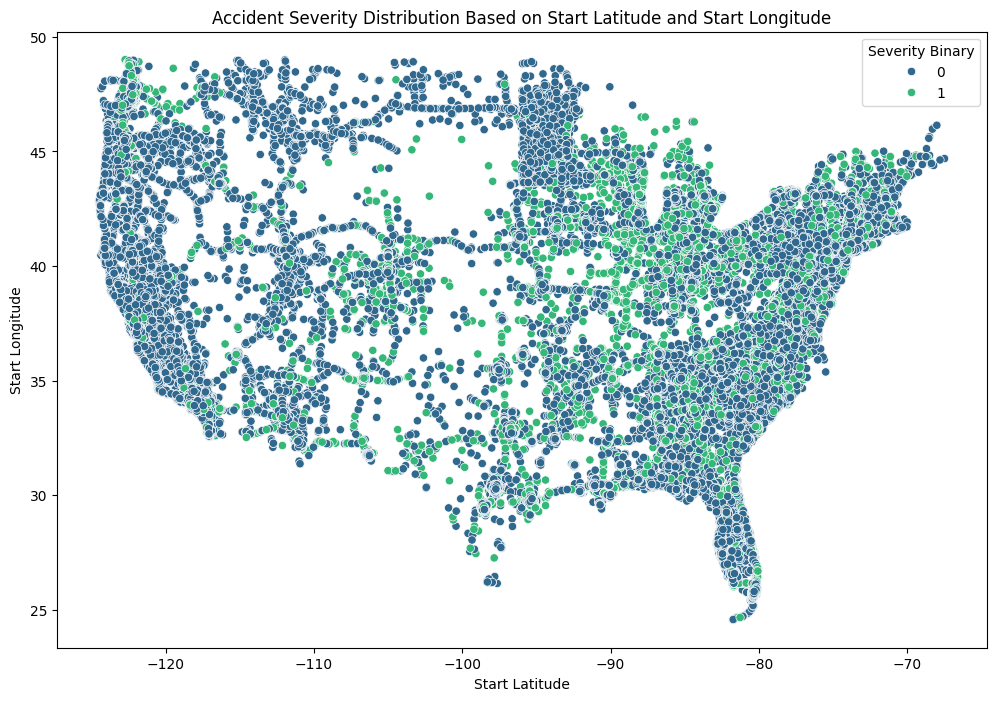

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns

# Assuming 'data' is your DataFrame and it contains 'Start_Lat', 'Start_Lng', and 'Severity_Binary'
# Prepare the data
X = data[['Start_Lat', 'Start_Lng']]

# Apply DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples=5)  # Adjust eps and min_samples as needed
data['Cluster'] = dbscan.fit_predict(X)

# Sample the data to reduce the number of points plotted
#sampled_data = data.sample(n=50000, random_state=42)  # Adjust the sample size as needed

# Visualize the clusters
# plt.figure(figsize=(12, 8))
# sns.scatterplot(data=sampled_data, x='Start_Lat', y='Start_Lng', hue='Cluster', palette='viridis', legend='full')
# plt.title('DBSCAN Clustering of Severity Based on Start_Lat and Start_Lng')
# plt.xlabel('Start_Lat')
# plt.ylabel('Start_Lng')
# plt.legend(title='Cluster')
# plt.show()

# Optionally, you can also visualize the severity within clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='Start_Lng', y='Start_Lat', hue='Severity_Binary', palette='viridis', legend='full')
plt.title('Accident Severity Distribution Based on Start Latitude and Start Longitude')
plt.xlabel('Start Latitude')
plt.ylabel('Start Longitude')
plt.legend(title='Severity Binary')
plt.show()

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Extract the coordinates of accidents with binary severity 1
accident_coords = data[data['Severity_Binary'] == 1][['Start_Lat', 'Start_Lng']].values

# Use DBSCAN to identify clusters of diseased squirrels
dbscan = DBSCAN(eps=0.0002, min_samples=2)
accident_clusters = dbscan.fit_predict(accident_coords)

# Get the coordinates of the cluster centers
cluster_centers = []
for cluster in set(accident_clusters):
    if cluster != -1:  # Ignore noise points
        cluster_points = accident_coords[accident_clusters == cluster]
        cluster_center = cluster_points.mean(axis=0)
        cluster_centers.append(cluster_center)

cluster_centers = np.array(cluster_centers)

# Calculate the distance from each accident to the nearest severe accident cluster
nbrs = NearestNeighbors(n_neighbors=1).fit(cluster_centers)
distances, _ = nbrs.kneighbors(data[['Start_Lat', 'Start_Lng']].values)

# Create the 'hotspots' feature based on the distances
data['hotspots'] = distances

<Axes: >

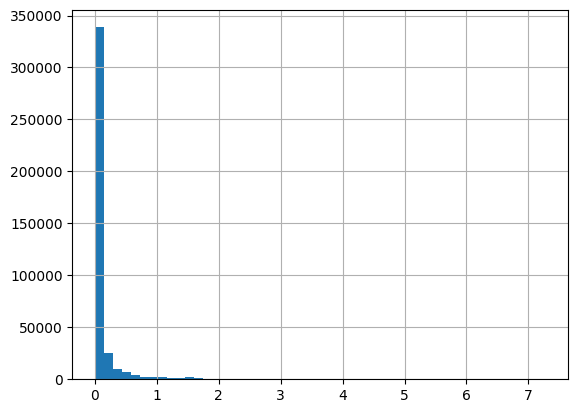

In [33]:
# small hotspot values indicate that the accident is close to a severe accident cluster
data['hotspots'].hist(bins=50)

In [34]:
corr_hotspots = data['hotspots'].corr(data['Severity_Binary'])
corr_hotspots

np.float64(-0.09074203748768916)

In [ ]:
data

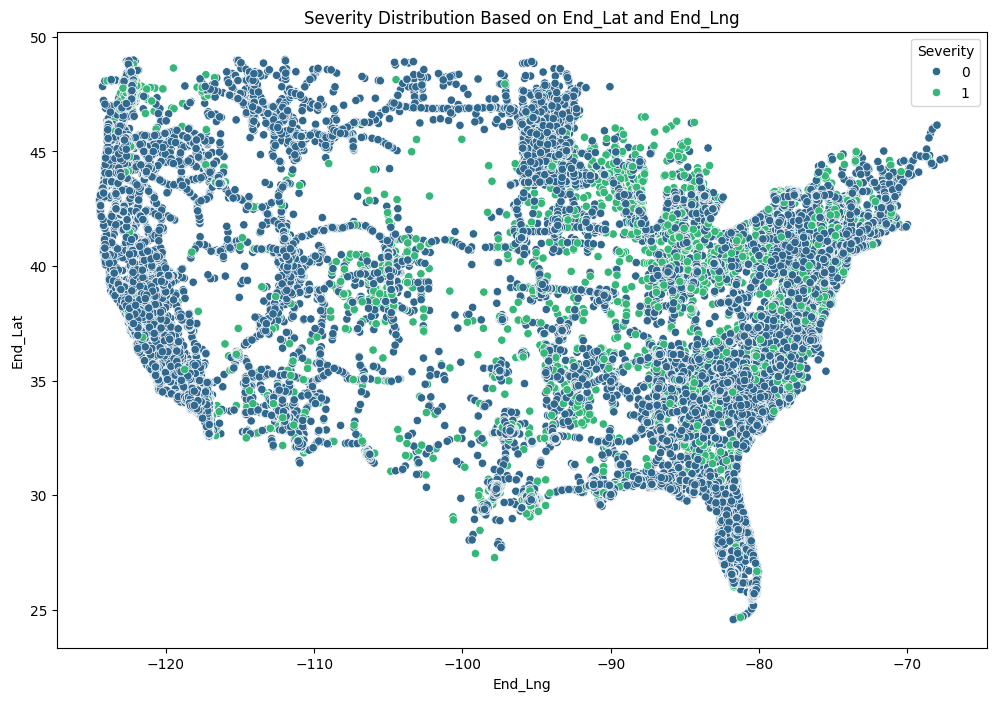

In [35]:

# Assuming 'data' is your DataFrame and it contains 'Start_Lat', 'Start_Lng', and 'Severity_Binary'
# Prepare the data
Z = data[['End_Lat', 'End_Lng']]

# Drop rows with NaN values in the relevant columns
Z_clean = Z.dropna()

# Apply DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples=5)  # Adjust eps and min_samples as needed
data_clean = data.loc[Z_clean.index]  # Keep only the rows that are in X_clean
data_clean['Cluster'] = dbscan.fit_predict(Z_clean)



# # Visualize the clusters
# plt.figure(figsize=(12, 8))
# sns.scatterplot(data=data_data, x='Start_Lat', y='Start_Lng', hue='Cluster', palette='viridis', legend='full')
# plt.title('DBSCAN Clustering of Severity Based on Start_Lat and Start_Lng')
# plt.xlabel('Start_Lat')
# plt.ylabel('Start_Lng')
# plt.legend(title='Cluster')
# plt.show()

# Optionally, you can also visualize the severity within clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='End_Lng', y='End_Lat', hue='Severity_Binary', palette='viridis', legend='full')
plt.title('Severity Distribution Based on End_Lat and End_Lng')
plt.xlabel('End_Lng')
plt.ylabel('End_Lat')
plt.legend(title='Severity')
plt.show()

Extracting Time Features

C:\Users\Alan\AppData\Local\Temp\ipykernel_28400\3885394725.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Start_Year'] = data['Start_Time'].dt.year
C:\Users\Alan\AppData\Local\Temp\ipykernel_28400\3885394725.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Start_Month'] = data['Start_Time'].dt.month
C:\Users\Alan\AppData\Local\Temp\ipykernel_28400\3885394725.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

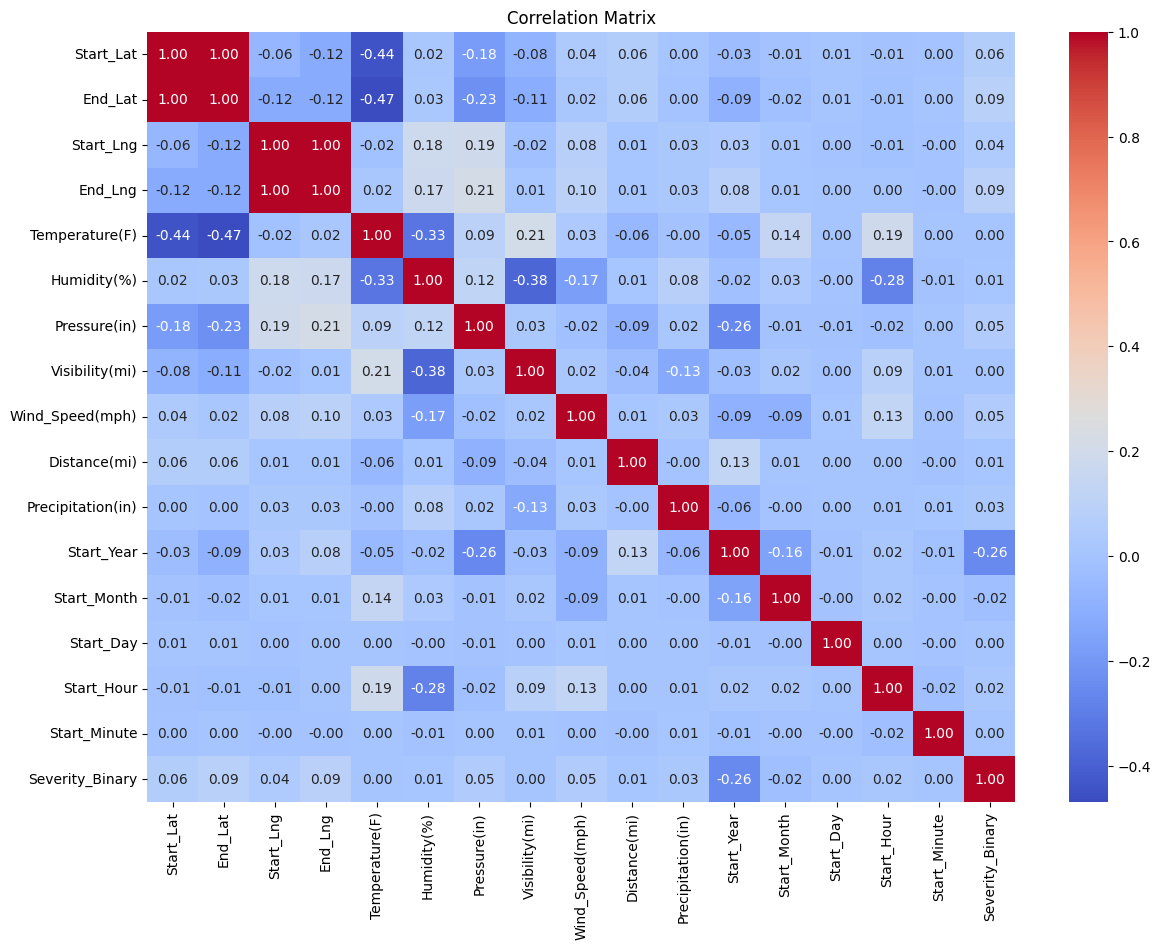

In [36]:
# Convert 'Start_Time' to datetime if it's not already
data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors='coerce')

# Drop rows with NaT values in 'Start_Time' after conversion
data = data.dropna(subset=['Start_Time'])

# Extract numerical features from the datetime column
data['Start_Year'] = data['Start_Time'].dt.year
data['Start_Month'] = data['Start_Time'].dt.month
data['Start_Day'] = data['Start_Time'].dt.day
data['Start_Hour'] = data['Start_Time'].dt.hour
data['Start_Minute'] = data['Start_Time'].dt.minute

# Select the features for the correlation matrix
time_attrs = ["Start_Lat", "End_Lat", "Start_Lng", "End_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", 
         "Visibility(mi)", "Wind_Speed(mph)", "Distance(mi)", "Precipitation(in)", "Start_Year", "Start_Month", "Start_Day", 
         "Start_Hour", "Start_Minute", "Severity_Binary"]

# Create the correlation matrix
corr_time = data[time_attrs].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_time, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

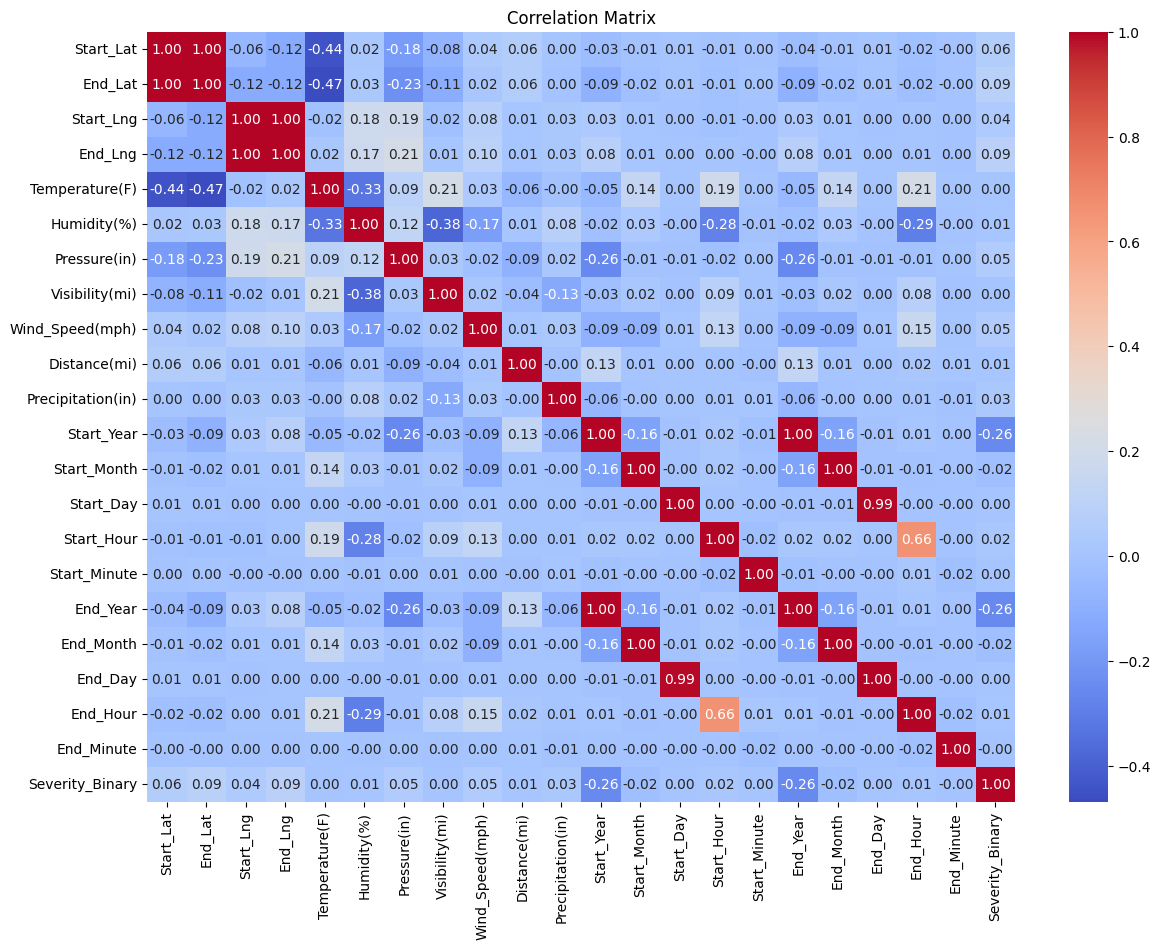

In [37]:
# Convert 'End_Time' to datetime if it's not already
data['End_Time'] = pd.to_datetime(data['End_Time'], errors='coerce')

# Drop rows with NaT values in 'Start_Time' after conversion
data = data.dropna(subset=['End_Time'])

# Extract numerical features from the datetime column
data['End_Year'] = data['End_Time'].dt.year
data['End_Month'] = data['End_Time'].dt.month
data['End_Day'] = data['End_Time'].dt.day
data['End_Hour'] = data['End_Time'].dt.hour
data['End_Minute'] = data['End_Time'].dt.minute

# Select the features for the correlation matrix
SE_attrs = ["Start_Lat", "End_Lat", "Start_Lng", "End_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", 
         "Visibility(mi)", "Wind_Speed(mph)", "Distance(mi)", "Precipitation(in)", "Start_Year", "Start_Month", "Start_Day", 
         "Start_Hour", "Start_Minute", "End_Year", "End_Month", "End_Day", "End_Hour", "End_Minute","Severity_Binary"]

# Create the correlation matrix
corr_SE = data[SE_attrs].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_SE, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Distances and Durations Correlation - decent linear correlation: .81
scatter_plot(
    'Distance (unknown units)', data['dist'],
    'Duration (minutes)', data['duration'] / 60,
    extra = lambda: plt.ylim(0, 150)
)
corr('dist', 'duration')

Creating duration feature from start time and end time

In [38]:
# create accident duration by simply subtracting the start time from the end time
data['duration'] = data['End_Time'] - data['Start_Time']

In [50]:
data["duration"].describe()

count                       361589
mean     0 days 06:31:50.102254216
std      8 days 15:56:30.901387359
min                0 days 00:02:30
25%                0 days 00:30:00
50%                0 days 01:02:36
75%                0 days 02:02:41
max             1553 days 00:10:38
Name: duration, dtype: object

In [51]:
data["duration"].value_counts()

duration
0 days 06:00:00    19140
0 days 00:30:00     5900
0 days 00:45:00     3593
0 days 01:00:00     3010
0 days 04:00:00     2941
                   ...  
0 days 05:01:33        1
0 days 09:13:51        1
0 days 04:48:32        1
0 days 04:05:55        1
0 days 02:57:41        1
Name: count, Length: 24161, dtype: int64

In [41]:
# Convert the duration to a numerical value (e.g., total seconds)
data['duration_seconds'] = data['duration'].dt.total_seconds()

In [74]:
data["duration_seconds"].describe()

count      361589.00
mean        23510.10
std        748590.90
min           150.00
25%          1800.00
50%          3756.00
75%          7361.00
max     134179838.00
Name: duration_seconds, dtype: float64

In [53]:
data["duration_seconds"].value_counts()

duration_seconds
21600.0    19140
1800.0      5900
2700.0      3593
3600.0      3010
14400.0     2941
           ...  
18093.0        1
33231.0        1
17312.0        1
14755.0        1
10661.0        1
Name: count, Length: 24161, dtype: int64

Text(0, 0.5, 'Count')

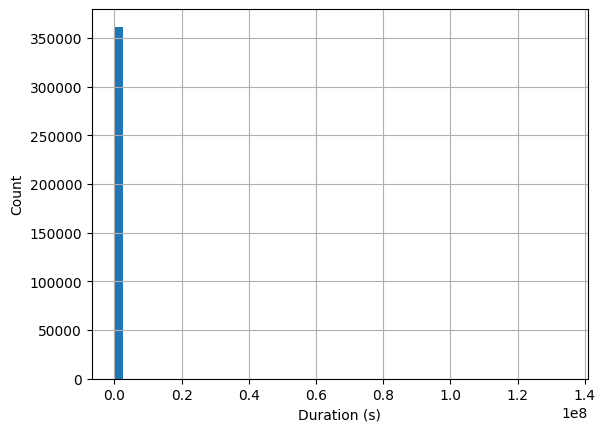

In [57]:
data["duration_seconds"].hist(bins=50)
plt.xlabel("Duration (s)")
plt.ylabel("Count")

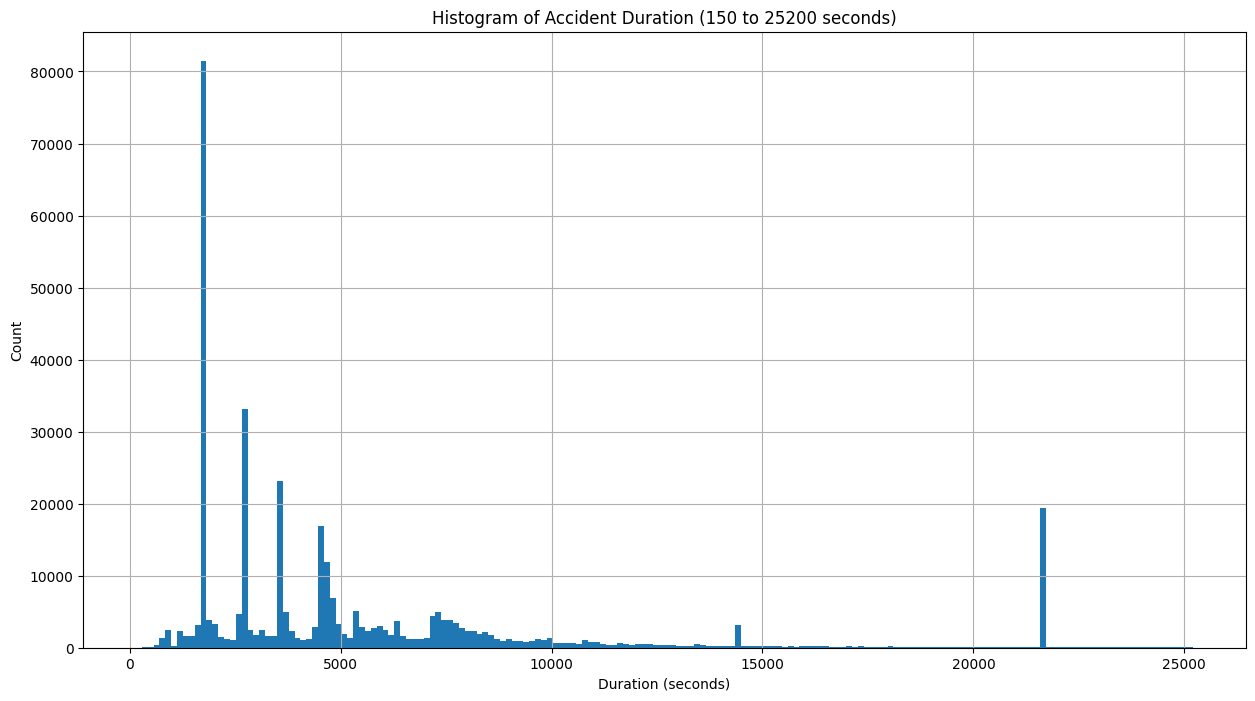

Percentage of durations between 150 and 25200 seconds: 97.56%
Percentage of negative durations: 0.00%
Percentage of zero durations: 0.00%


In [75]:
duration_seconds = data["duration_seconds"]

# Filter and plot the histogram
duration_seconds[(duration_seconds >= 150) & (duration_seconds <= 25200)].hist(bins=180, figsize=(15, 8))
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Histogram of Accident Duration (150 to 25200 seconds)")
plt.show()

# Calculate and print the percentages
percentage_within_range = ((duration_seconds > 150) & (duration_seconds < 25200)).sum() / len(data) * 100
percentage_negative = (duration_seconds < 0).sum() / len(data) * 100
percentage_zero = (duration_seconds == 0).sum() / len(data) * 100

print(f"Percentage of durations between 150 and 25200 seconds: {percentage_within_range:.2f}%")
print(f"Percentage of negative durations: {percentage_negative:.2f}%")
print(f"Percentage of zero durations: {percentage_zero:.2f}%")

In [47]:
data['duration_minutes'] = data['duration_seconds'] / 60

In [ ]:
# Set the display format for floating-point numbers to non-scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Display the description of the 'duration_seconds' column
print(data["duration_minutes"].describe())

count    361589.00
mean        391.84
std       12476.52
min           2.50
25%          30.00
50%          62.60
75%         122.68
max     2236330.63
Name: duration_minutes, dtype: float64


In [59]:
data["duration_minutes"].value_counts()

duration_minutes
360.00    19140
30.00      5900
45.00      3593
60.00      3010
240.00     2941
          ...  
301.55        1
553.85        1
288.53        1
245.92        1
177.68        1
Name: count, Length: 24161, dtype: int64

Text(0, 0.5, 'Count')

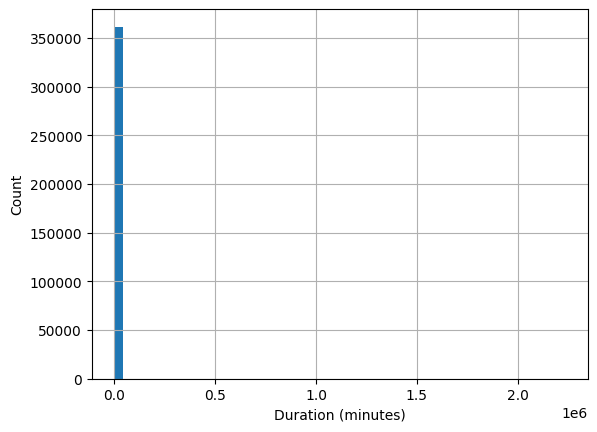

In [58]:
data["duration_minutes"].hist(bins=50)
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")

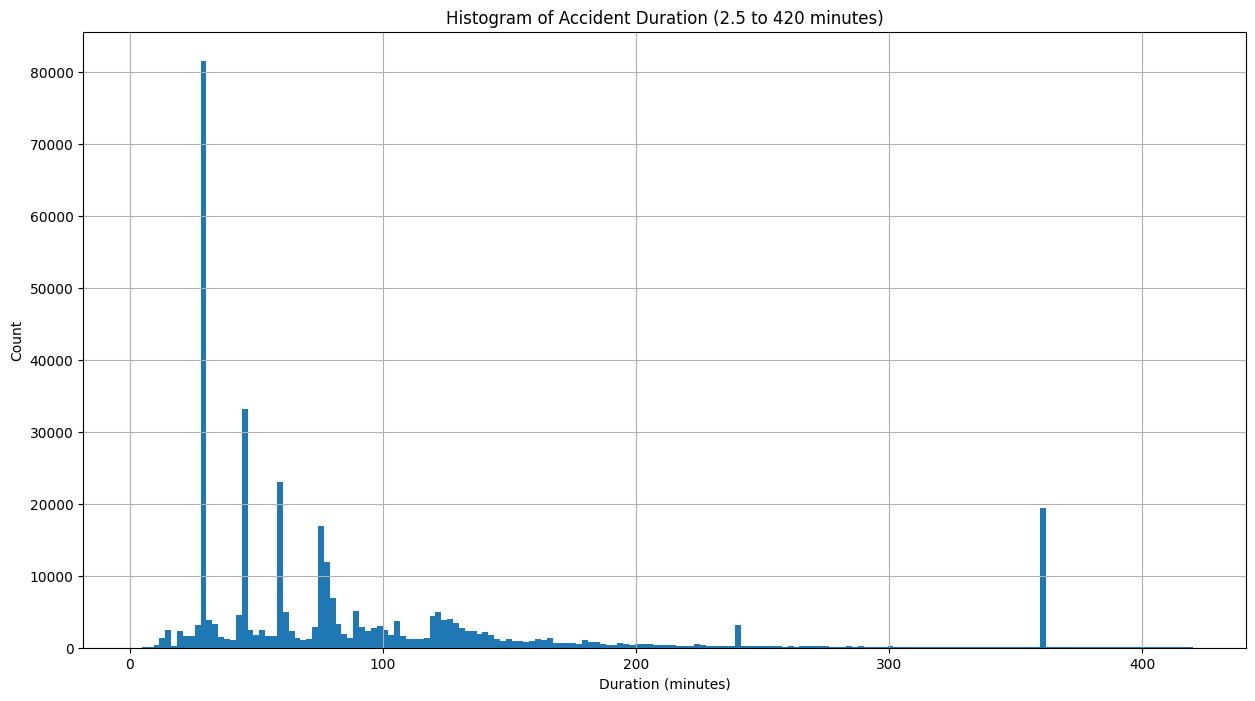

Percentage of durations between 2.5 and 420 minutes: 97.56%
Percentage of negative durations: 0.00%
Percentage of zero durations: 0.00%


In [73]:
duration_minutes = data["duration_minutes"]

# Filter and plot the histogram
duration_minutes[(duration_minutes >= 2.5) & (duration_minutes <= 420)].hist(bins=180, figsize=(15, 8))
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.title("Histogram of Accident Duration (2.5 to 420 minutes)")
plt.show()

# Calculate and print the percentages
percentage_within_range = ((duration_minutes > 2.5) & (duration_minutes < 420)).sum() / len(data) * 100
percentage_negative = (duration_minutes < 0).sum() / len(data) * 100
percentage_zero = (duration_minutes == 0).sum() / len(data) * 100

print(f"Percentage of durations between 2.5 and 420 minutes: {percentage_within_range:.2f}%")
print(f"Percentage of negative durations: {percentage_negative:.2f}%")
print(f"Percentage of zero durations: {percentage_zero:.2f}%")

In [60]:
data['duration_hours'] = data['duration_minutes'] / 60

In [61]:
print(data["duration_hours"].describe())

count   361589.00
mean         6.53
std        207.94
min          0.04
25%          0.50
50%          1.04
75%          2.04
max      37272.18
Name: duration_hours, dtype: float64


In [62]:
data["duration_hours"].value_counts()

duration_hours
6.00    19140
0.50     5900
0.75     3593
1.00     3010
4.00     2941
        ...  
5.03        1
9.23        1
4.81        1
4.10        1
2.96        1
Name: count, Length: 24161, dtype: int64

np.float64(17.21153021800995)

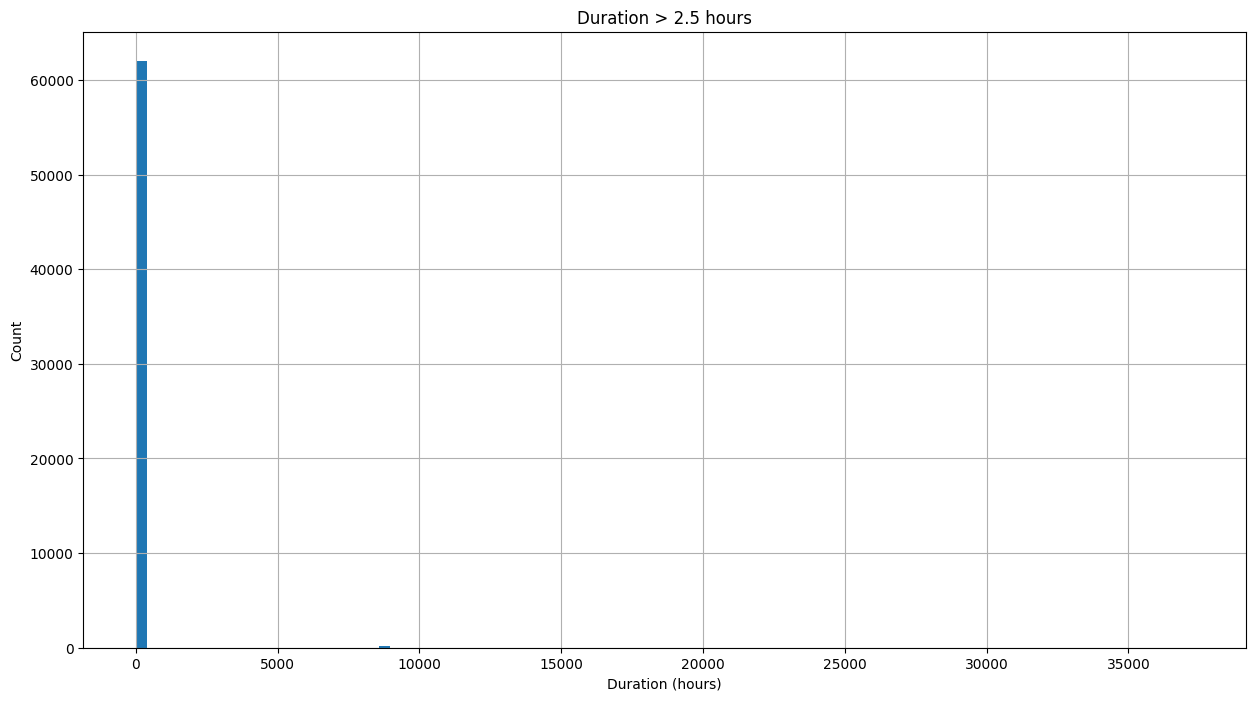

In [65]:
# Look at just the large "outliers" (anything above 2.5 hours - total of <0.1% data)
# That spike at 24 hours is an artifact of the system, definitely an outlier to remove
plt.title("Duration > 2.5 hours")
duration = data["duration_seconds"]
hours = duration / 3600
hours[hours >= 2.5].hist(bins=100, figsize=(15, 8))
plt.xlabel("Duration (hours)")
plt.ylabel("Count")
(hours >= 2.5).sum() / len(data) * 100

(np.float64(0.0), np.float64(0.0), np.float64(0.0))

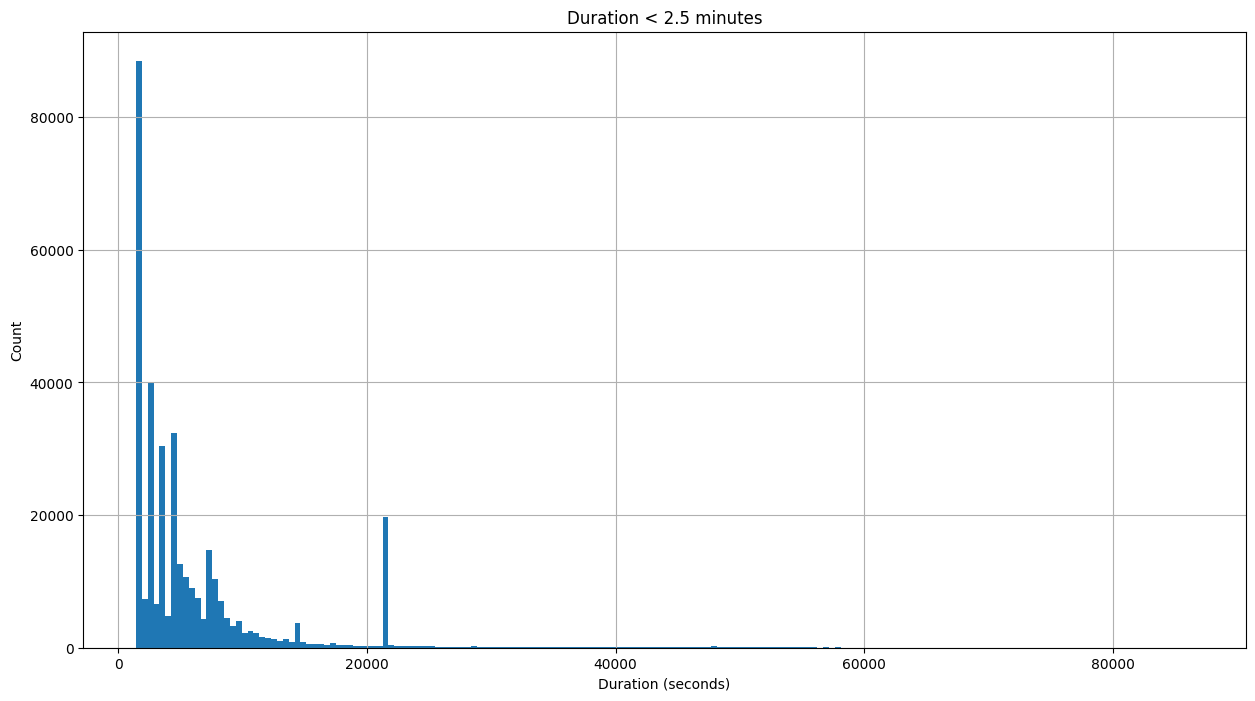

In [66]:
# Look at just the small values (anything a few minutes)
# There is a trough at 50 seconds that may indicate value below that are primarily noise or aborted trips
# To be on the safe side, we'll remove all trips below 30 seconds only (total of <0.9% data not including negative and zero values)
duration[(hours >= 0.4) & (hours < 24)].hist(bins=180, figsize=(15, 8))
plt.title("Duration < 2.5 minutes")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
((duration > 0) & (duration < 30)).sum() / len(data) * 100, (duration < 0).sum() / len(data) * 100, (duration == 0).sum() / len(data) * 100

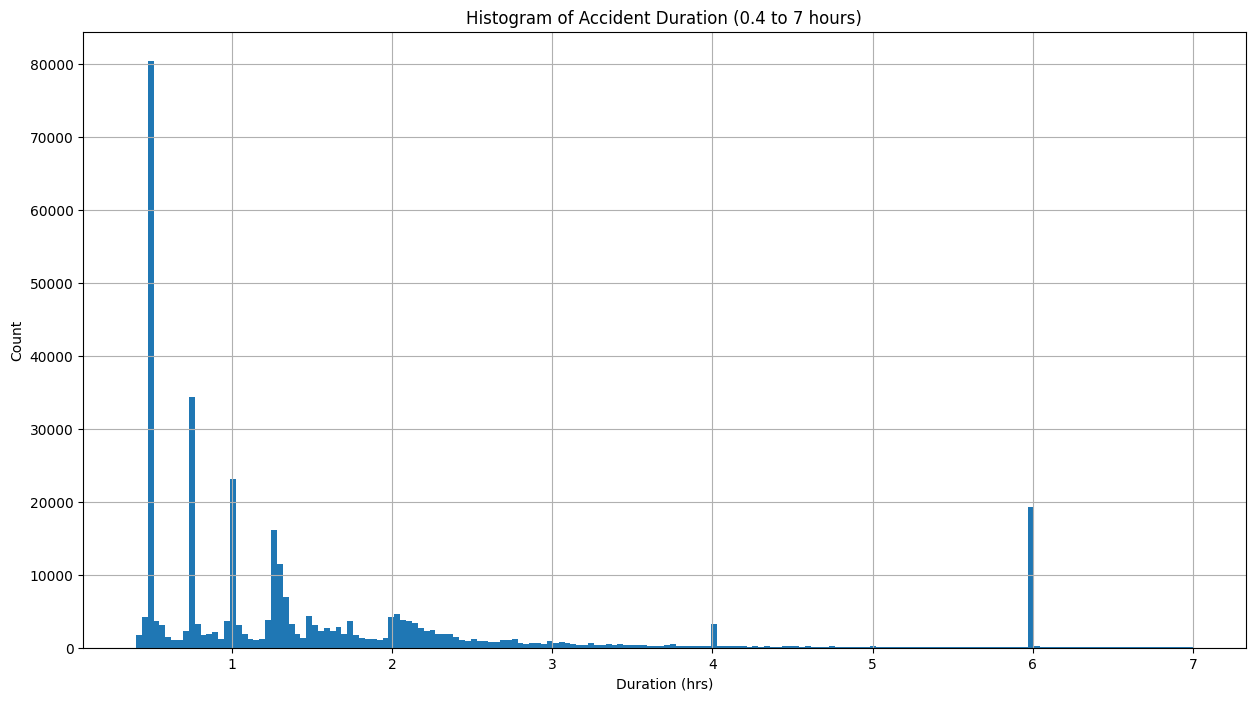

Percentage of durations between 0.4 and 7 hours: 95.07%
Percentage of negative durations: 0.00%
Percentage of zero durations: 0.00%


In [72]:
duration_hours = data["duration_hours"]

# Filter and plot the histogram
duration_hours[(duration_hours >= 0.4) & (duration_hours <= 7)].hist(bins=180, figsize=(15, 8))
plt.xlabel("Duration (hrs)")
plt.ylabel("Count")
plt.title("Histogram of Accident Duration (0.4 to 7 hours)")
plt.show()

# Calculate and print the percentages
percentage_within_range = ((duration_hours > 0.4) & (duration_hours < 7)).sum() / len(data) * 100
percentage_negative = (duration_hours < 0).sum() / len(data) * 100
percentage_zero = (duration_hours == 0).sum() / len(data) * 100

print(f"Percentage of durations between 0.4 and 7 hours: {percentage_within_range:.2f}%")
print(f"Percentage of negative durations: {percentage_negative:.2f}%")
print(f"Percentage of zero durations: {percentage_zero:.2f}%")